# Predictive Maintenance Using LSTM Deep Learning

## Import Libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
import copy
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')

%matplotlib inline

# print(tf.test.is_built_with_cuda())
# print(tf.device("GPU:0"))

## Define constants

In [2]:
# Directories
DATA_DIR = "data"
DATA_CSV = "gesits_prod_util_20201118.csv"
MODEL_DIR = "models"

# For data preparation and modelling purposes
WINDOW_SIZE = 3
BATCH_SIZE = 300
BUFFER_SIZE = 5000
LR_START = 1e-5
EPOCHS = 100

## Data Understanding

Load the data using pandas

In [3]:
df_usage = pd.read_csv(f"./{DATA_DIR}/{DATA_CSV}")
df_usage

,sreg,ac_full_type,msn,body_type,type_of_big_part,ori_position,created_on,start_period,end_period,flight_cycle,flight_hour
0,PK-GFR,B737-800NG,39417,NB,AIRFRAME,NaN,2020-02-07 16:06:06,2020-01-01 00:00:00,2020-01-31 00:00:00,125.0,240:18:00
1,PK-GFR,B737-800NG,39417,NB,ENGINE,Pos 1,2020-02-07 16:06:06,2020-01-01 00:00:00,2020-01-31 00:00:00,111.0,212:18:00
2,PK-GFR,B737-800NG,39417,NB,ENGINE,Pos 2,2020-02-07 16:06:06,2020-01-01 00:00:00,2020-01-31 00:00:00,97.0,118:46:00
3,PK-GFR,B737-800NG,39417,NB,APU,NaN,2020-02-07 16:06:06,2020-01-01 00:00:00,2020-01-31 00:00:00,174.0,232:00:00
4,PK-GFR,B737-800NG,39417,NB,LG,NaN,2020-02-07 16:06:06,2020-01-01 00:00:00,2020-01-31 00:00:00,125.0,240:18:00
...,...,...,...,...,...,...,...,...,...,...,...
3254,PK-GPY,Airbus 330-300,1671,WB,AIRFRAME,NaN,NaN,NaN,NaN,NaN,NaN
3255,PK-GEM,B737-800NG,29928,NB,LG,NaN,NaN,NaN,NaN,NaN,NaN
3256,PK-GMX,B737-800NG,38070,NB,LG,NaN,NaN,NaN,NaN,NaN,NaN
3257,PK-GFN,B737-800NG,38033,NB,ENGINE,Pos 2,NaN,NaN,NaN,NaN,NaN


Below is the definition of each field in the .csv dataset.

| **Field** | Definition |
|---|---|
| `sreg` | Registration ID of each aircraft |
| `ac_full_type` | Aircraft model of each registration |
| `msn` | Aircraft model serial number of each registration |
| `body_type` | Aircraft cabin type, either NB (Narrow Body) or WB (Wide Body) |
| `type_of_big_part` | The type of big part whose utilization is recorded |
| `ori_position` | The position of the big part on the plane, only applies to `ENGINE` big part |
| `created_on` | Timestamp of when the data is created |
| `start_period` | Initial period of the utilization recording of a big part |
| `end_period` | Final period of the utilization recording of a big part |
| `flight_cycle` | Number of flight cycle utilization of a big part in the recorded period |
| `flight_hour` | Number of flight hour utilization of a big part in the recorded period, still in `<hour>:<minute>:<second>` format |

## Data Cleaning

Next, we do data cleaning by removing or dropping rows that don't have both `flight_cycle` and `flight_hour` values, since they don't bring any data for the model later.

We also are going to merge the value of `type_of_big_part` and `ori_position` for the `engines` big part.

In [4]:
# Dropping rows that don't have both flight_cycle and flight_hour values
df_usage.dropna(subset=["flight_cycle","flight_hour"], how="all", inplace=True)

# Fill NaN values in ori_position with empty strings as it's only going to be applied to `ENGINE` big part
df_usage["ori_position"].fillna('', inplace=True)
df_usage["type_of_big_part"] = df_usage["type_of_big_part"] + df_usage["ori_position"]

# Drop `ori_position` column as it is no longer useful for training
df_usage.drop(columns=["ori_position"], axis=1, inplace=True)

df_usage

,sreg,ac_full_type,msn,body_type,type_of_big_part,created_on,start_period,end_period,flight_cycle,flight_hour
0,PK-GFR,B737-800NG,39417,NB,AIRFRAME,2020-02-07 16:06:06,2020-01-01 00:00:00,2020-01-31 00:00:00,125.0,240:18:00
1,PK-GFR,B737-800NG,39417,NB,ENGINEPos 1,2020-02-07 16:06:06,2020-01-01 00:00:00,2020-01-31 00:00:00,111.0,212:18:00
2,PK-GFR,B737-800NG,39417,NB,ENGINEPos 2,2020-02-07 16:06:06,2020-01-01 00:00:00,2020-01-31 00:00:00,97.0,118:46:00
3,PK-GFR,B737-800NG,39417,NB,APU,2020-02-07 16:06:06,2020-01-01 00:00:00,2020-01-31 00:00:00,174.0,232:00:00
4,PK-GFR,B737-800NG,39417,NB,LG,2020-02-07 16:06:06,2020-01-01 00:00:00,2020-01-31 00:00:00,125.0,240:18:00
...,...,...,...,...,...,...,...,...,...,...
2986,PK-GIE,Boeing 777-300ER,29147,WB,AIRFRAME,2020-11-17 12:56:30,2020-10-01 00:00:00,2020-10-31 00:00:00,7.0,012:57:00
2987,PK-GIE,Boeing 777-300ER,29147,WB,APU,2020-11-17 12:56:30,2020-10-01 00:00:00,2020-10-31 00:00:00,30.0,040:00:00
2988,PK-GIE,Boeing 777-300ER,29147,WB,ENGINEPos 1,2020-11-17 12:56:30,2020-10-01 00:00:00,2020-10-31 00:00:00,7.0,012:57:00
2989,PK-GIE,Boeing 777-300ER,29147,WB,ENGINEPos 2,2020-11-17 12:56:30,2020-10-01 00:00:00,2020-10-31 00:00:00,7.0,012:57:00


Then we're going to convert the strings on `created_on`, `start_period`, and `end_period` to date time to make it easier to process.

In [5]:
df_usage["created_on"] = pd.to_datetime(df_usage["created_on"])
df_usage["start_period"] = pd.to_datetime(df_usage["start_period"])
df_usage["end_period"] = pd.to_datetime(df_usage["end_period"])
df_usage

,sreg,ac_full_type,msn,body_type,type_of_big_part,created_on,start_period,end_period,flight_cycle,flight_hour
0,PK-GFR,B737-800NG,39417,NB,AIRFRAME,2020-02-07 16:06:06,2020-01-01,2020-01-31,125.0,240:18:00
1,PK-GFR,B737-800NG,39417,NB,ENGINEPos 1,2020-02-07 16:06:06,2020-01-01,2020-01-31,111.0,212:18:00
2,PK-GFR,B737-800NG,39417,NB,ENGINEPos 2,2020-02-07 16:06:06,2020-01-01,2020-01-31,97.0,118:46:00
3,PK-GFR,B737-800NG,39417,NB,APU,2020-02-07 16:06:06,2020-01-01,2020-01-31,174.0,232:00:00
4,PK-GFR,B737-800NG,39417,NB,LG,2020-02-07 16:06:06,2020-01-01,2020-01-31,125.0,240:18:00
...,...,...,...,...,...,...,...,...,...,...
2986,PK-GIE,Boeing 777-300ER,29147,WB,AIRFRAME,2020-11-17 12:56:30,2020-10-01,2020-10-31,7.0,012:57:00
2987,PK-GIE,Boeing 777-300ER,29147,WB,APU,2020-11-17 12:56:30,2020-10-01,2020-10-31,30.0,040:00:00
2988,PK-GIE,Boeing 777-300ER,29147,WB,ENGINEPos 1,2020-11-17 12:56:30,2020-10-01,2020-10-31,7.0,012:57:00
2989,PK-GIE,Boeing 777-300ER,29147,WB,ENGINEPos 2,2020-11-17 12:56:30,2020-10-01,2020-10-31,7.0,012:57:00


We also need to drop duplicates by these grouping:
- `sreg`
- `ac_full_type`
- `msn`
- `type_of_big_part`
- `start_period`
- `end_period`

After doing so, since we're dealing with a sequenced data, we need to sort the data based on the creation of the data.

In [6]:
df_usage = df_usage.drop_duplicates(subset=["sreg","ac_full_type","msn","type_of_big_part","start_period","end_period"], keep="last")
df_usage.sort_values(by="created_on")
df_usage

,sreg,ac_full_type,msn,body_type,type_of_big_part,created_on,start_period,end_period,flight_cycle,flight_hour
0,PK-GFR,B737-800NG,39417,NB,AIRFRAME,2020-02-07 16:06:06,2020-01-01,2020-01-31,125.0,240:18:00
1,PK-GFR,B737-800NG,39417,NB,ENGINEPos 1,2020-02-07 16:06:06,2020-01-01,2020-01-31,111.0,212:18:00
2,PK-GFR,B737-800NG,39417,NB,ENGINEPos 2,2020-02-07 16:06:06,2020-01-01,2020-01-31,97.0,118:46:00
3,PK-GFR,B737-800NG,39417,NB,APU,2020-02-07 16:06:06,2020-01-01,2020-01-31,174.0,232:00:00
4,PK-GFR,B737-800NG,39417,NB,LG,2020-02-07 16:06:06,2020-01-01,2020-01-31,125.0,240:18:00
...,...,...,...,...,...,...,...,...,...,...
2986,PK-GIE,Boeing 777-300ER,29147,WB,AIRFRAME,2020-11-17 12:56:30,2020-10-01,2020-10-31,7.0,012:57:00
2987,PK-GIE,Boeing 777-300ER,29147,WB,APU,2020-11-17 12:56:30,2020-10-01,2020-10-31,30.0,040:00:00
2988,PK-GIE,Boeing 777-300ER,29147,WB,ENGINEPos 1,2020-11-17 12:56:30,2020-10-01,2020-10-31,7.0,012:57:00
2989,PK-GIE,Boeing 777-300ER,29147,WB,ENGINEPos 2,2020-11-17 12:56:30,2020-10-01,2020-10-31,7.0,012:57:00


Next we're going to convert the flight hours format to hour(s) format. To do that, we define a helper function and apply to the dataframe.b

In [7]:
def hms2h(hms) :
  hms = hms.split(':')
  return float(hms[0]) + float(hms[1])/60 + float(hms[2])/3600

df_usage["flight_hour"] = df_usage.apply(lambda row: hms2h(row["flight_hour"]), axis=1)
df_usage

,sreg,ac_full_type,msn,body_type,type_of_big_part,created_on,start_period,end_period,flight_cycle,flight_hour
0,PK-GFR,B737-800NG,39417,NB,AIRFRAME,2020-02-07 16:06:06,2020-01-01,2020-01-31,125.0,240.300000
1,PK-GFR,B737-800NG,39417,NB,ENGINEPos 1,2020-02-07 16:06:06,2020-01-01,2020-01-31,111.0,212.300000
2,PK-GFR,B737-800NG,39417,NB,ENGINEPos 2,2020-02-07 16:06:06,2020-01-01,2020-01-31,97.0,118.766667
3,PK-GFR,B737-800NG,39417,NB,APU,2020-02-07 16:06:06,2020-01-01,2020-01-31,174.0,232.000000
4,PK-GFR,B737-800NG,39417,NB,LG,2020-02-07 16:06:06,2020-01-01,2020-01-31,125.0,240.300000
...,...,...,...,...,...,...,...,...,...,...
2986,PK-GIE,Boeing 777-300ER,29147,WB,AIRFRAME,2020-11-17 12:56:30,2020-10-01,2020-10-31,7.0,12.950000
2987,PK-GIE,Boeing 777-300ER,29147,WB,APU,2020-11-17 12:56:30,2020-10-01,2020-10-31,30.0,40.000000
2988,PK-GIE,Boeing 777-300ER,29147,WB,ENGINEPos 1,2020-11-17 12:56:30,2020-10-01,2020-10-31,7.0,12.950000
2989,PK-GIE,Boeing 777-300ER,29147,WB,ENGINEPos 2,2020-11-17 12:56:30,2020-10-01,2020-10-31,7.0,12.950000


Let's try to plot each type of big part's flight cycle for each `msn` to see how some sampled big parts usage looks like.

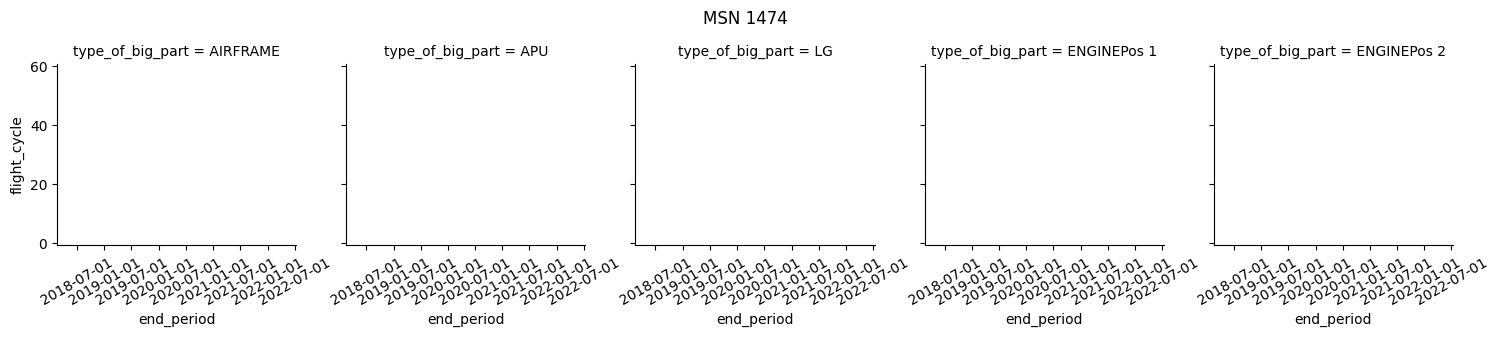

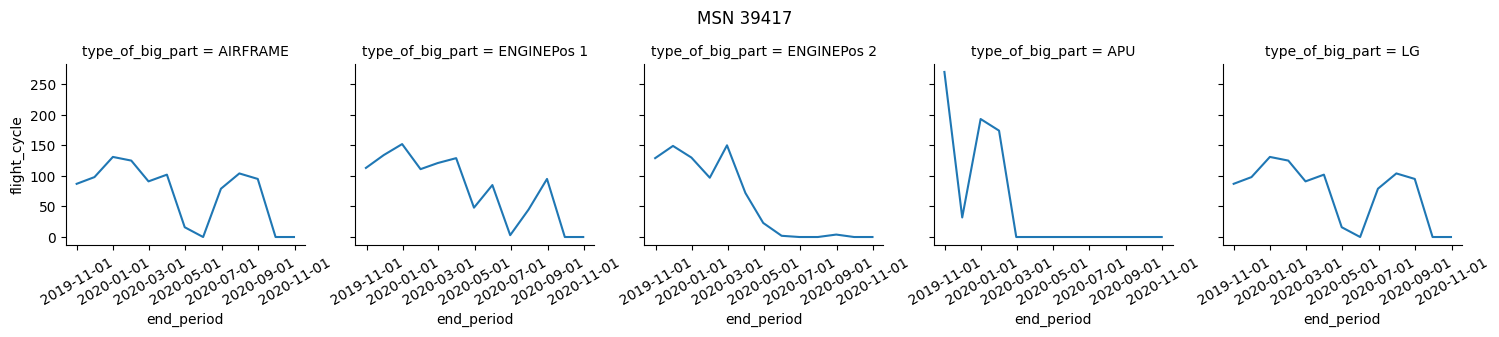

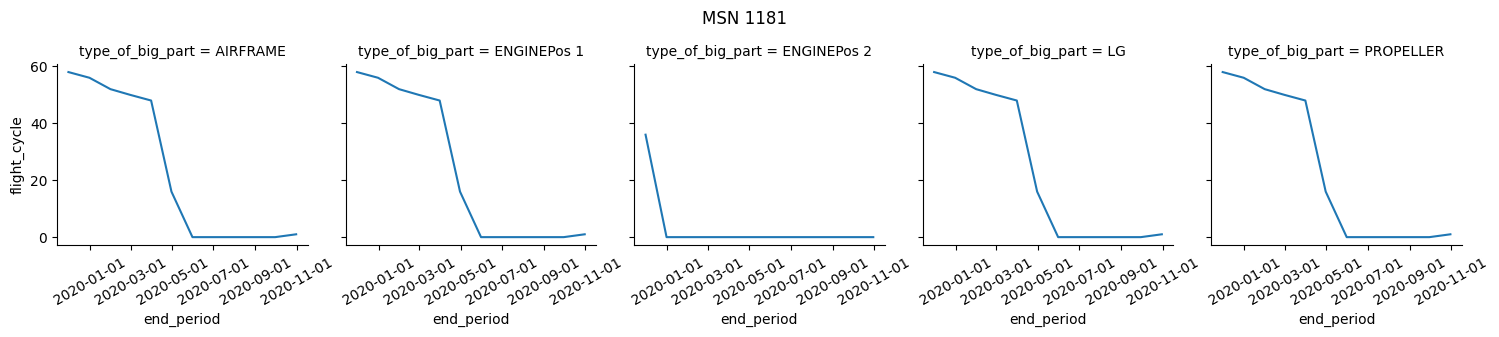

In [8]:
def plot_sample_msn(msns=None, n=3) :
  if not msns :
    msns = np.random.choice(df_usage["msn"].unique(), size=n)
  for msn in msns :
    data = df_usage.loc[df_usage["msn"] == msn]
    grid = sns.FacetGrid(data, col="type_of_big_part")
    grid.map(sns.lineplot, "end_period", "flight_cycle")
    plt.subplots_adjust(top=.8)
    grid.fig.suptitle(f"MSN {msn}")
    grid.set_xticklabels(rotation=30)
plot_sample_msn()

As seen on shown data, the availability of data varies between each MSN. We need to look for MSN with the most complete data if we're to build the most representative model. Let's take a look at the date range that we have in the data.

In [9]:
print(df_usage["end_period"].min())
print(df_usage["end_period"].max())

2019-09-30 00:00:00
2020-10-31 00:00:00


We have data dates ranging from **September 2019** to **October 2020**. Since the observation is recorded monthly, a complete observation of a big part type should have **14 data points**. Let's see which big parts of each MSN that has all these 14 data points.

In [10]:
df_temp = df_usage.groupby(by=["msn","type_of_big_part"]).count()[["flight_cycle","flight_hour"]]
df_temp.loc[(df_temp["flight_cycle"] >= 14) & (df_temp["flight_hour"] >= 14)]

flight_cycle  flight_hour
msn   type_of_big_part                           
38884 AIRFRAME                    14           14
      APU                         14           14
      ENGINEPos 1                 14           14
      ENGINEPos 2                 14           14
      LG                          14           14
38885 AIRFRAME                    14           14
      APU                         14           14
      ENGINEPos 1                 14           14
      ENGINEPos 2                 14           14
      LG                          14           14
41794 AIRFRAME                    14           14
      APU                         14           14
      ENGINEPos 1                 14           14
      ENGINEPos 2                 14           14
      LG                          14           14
41796 AIRFRAME                    14           14
      APU                         14           14
      ENGINEPos 1                 14           14
      ENGINEPos 2                 14           14
      LG                          14           14
41800 AIRFRAME                    14           14
      APU                         14           14
      ENGINEPos 1                 14           14
      ENGINEPos 2                 14           14
      LG                          14           14

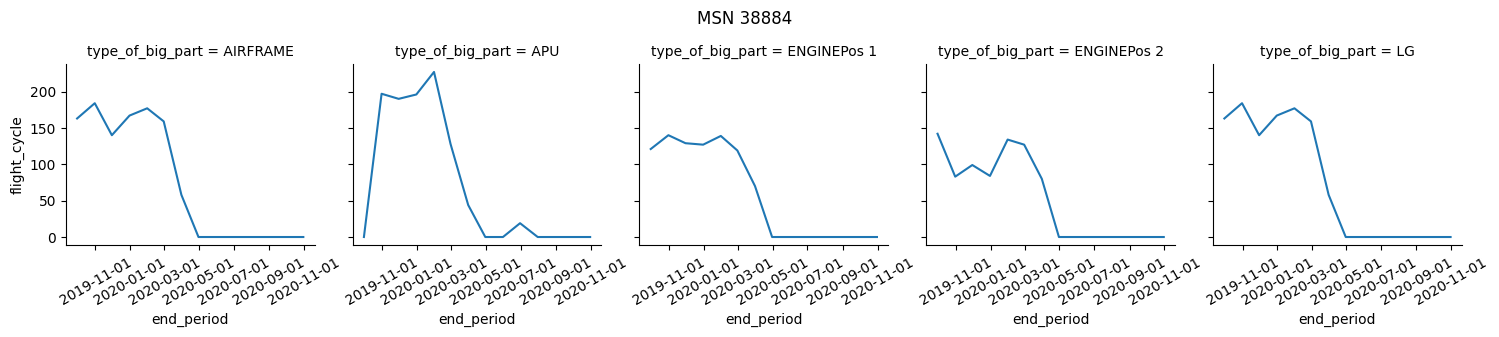

In [11]:
plot_sample_msn([38884])

Let's see if we can get better data with another approach.

Instead of taking data from `msn`s, let's try taking the data from the mean of each aircraft type. We might get better data by combining all aircrafts data into one. Let's see how many aircraft there is per aircraft type.

In [12]:
for ac_type in df_usage["ac_full_type"].unique() :
  msns = df_usage.groupby(["ac_full_type"]).agg({"msn": "unique"}).loc[ac_type]["msn"]
  print(ac_type, msns, len(msns))
print()
df_usage.groupby(["ac_full_type"]).agg({"msn": "nunique"})

B737-800NG [39417 38885 38884 41794 40547 41796 41800 38821 30155 41798 41605 41607
 41806 41815 41812 30151 36805 37885 39416 36850 38071 39891 36436 41310
 41322 39929 39955 41312 36549 39920 36830 38032 38043 38044 41267 39936
 39939 39954 38074 37887] 40
Bombardier-CRJ-1000 [19028 19033 19034 19038 19042 19043 19044 19032 19031 19039 19029 19030] 12
ATR72-600 [1140 1149 1152 1181 1191 1249 1321 1329 1132 1242 1254 1243 1398] 13
Boeing 777-300ER [40074 29146 40075 21944 29143 29148 29147 29145] 8
Airbus 330-300 [1577 1723 1733] 3
Airbus 330-200 [1288 1474] 2



,msn
ac_full_type,
ATR72-600,13
Airbus 330-200,2
Airbus 330-300,3
B737-800NG,40
Boeing 777-300ER,8
Bombardier-CRJ-1000,12


When combined, these data might help in aiding what little data we have. This might work for plentiful aircraft types like `B737-800NG`, but not so much for `Airbus 330-200` or `Airbus 330-300`.

Let's try making some modification to our earlier function to plot the `msn` samples, so that we can restrict the sampling to a specific aircraft type.

In [13]:
def plot_sample_msn(msns=None, n=3, act=None) :
  if not msns :
    if not act :
      msns = df_usage["msn"].unique()
    else :
      msns = df_usage.loc[df_usage["ac_full_type"] == act]
    msns = np.random.choice(msns["msn"], size=n)
  for msn in msns :
    data = df_usage.loc[df_usage["msn"] == msn]
    grid = sns.FacetGrid(data, col="type_of_big_part")
    grid.map(sns.lineplot, "end_period", "flight_cycle")
    plt.subplots_adjust(top=.8)
    grid.fig.suptitle(f"MSN {msn}")
    grid.set_xticklabels(rotation=30)

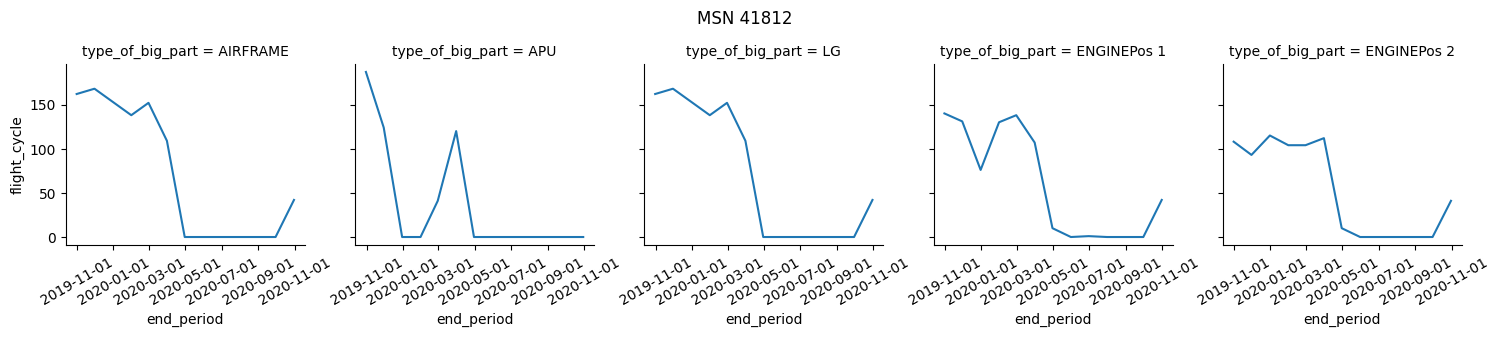

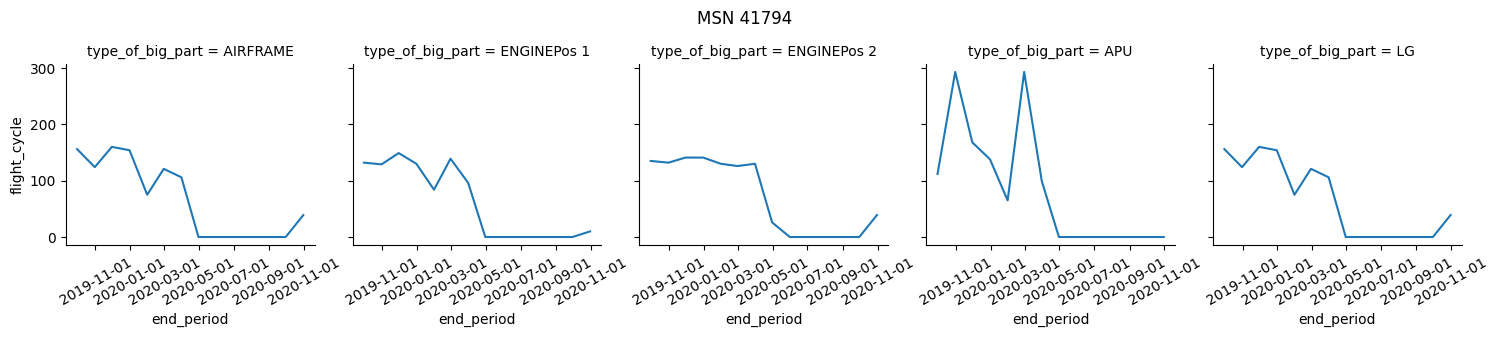

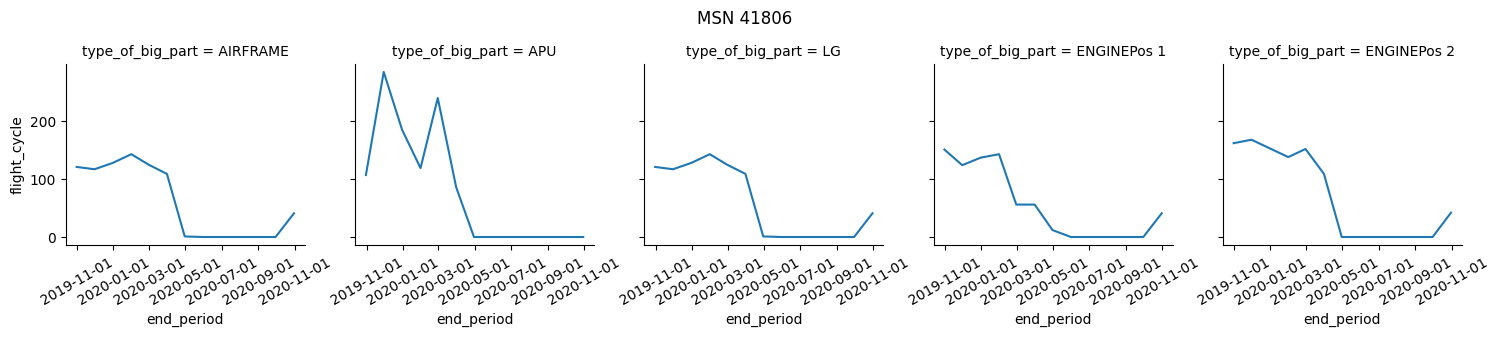

In [14]:
plot_sample_msn(act="B737-800NG")

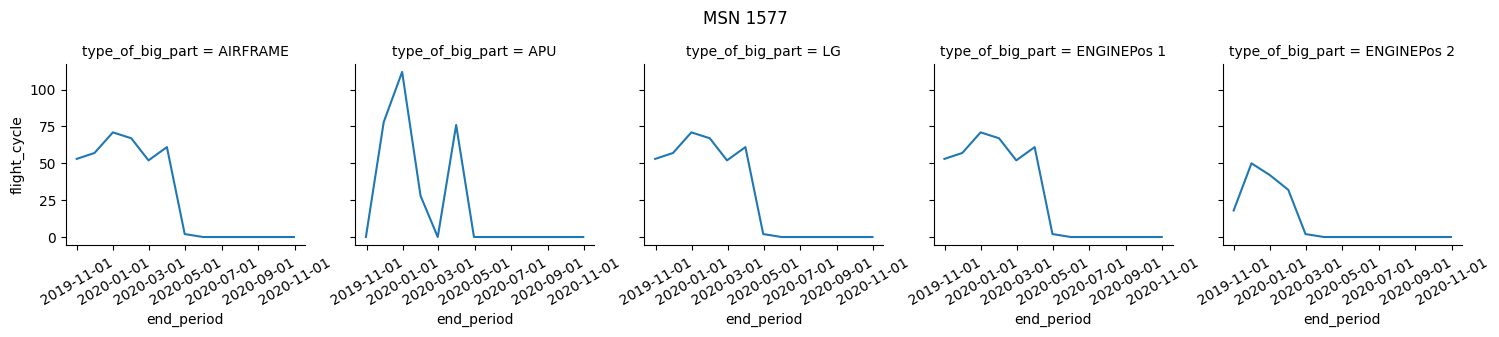

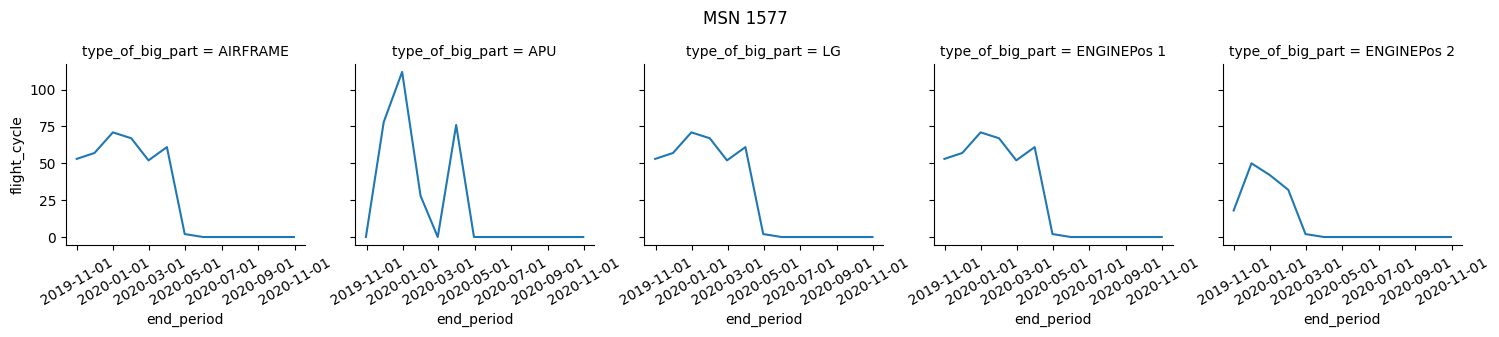

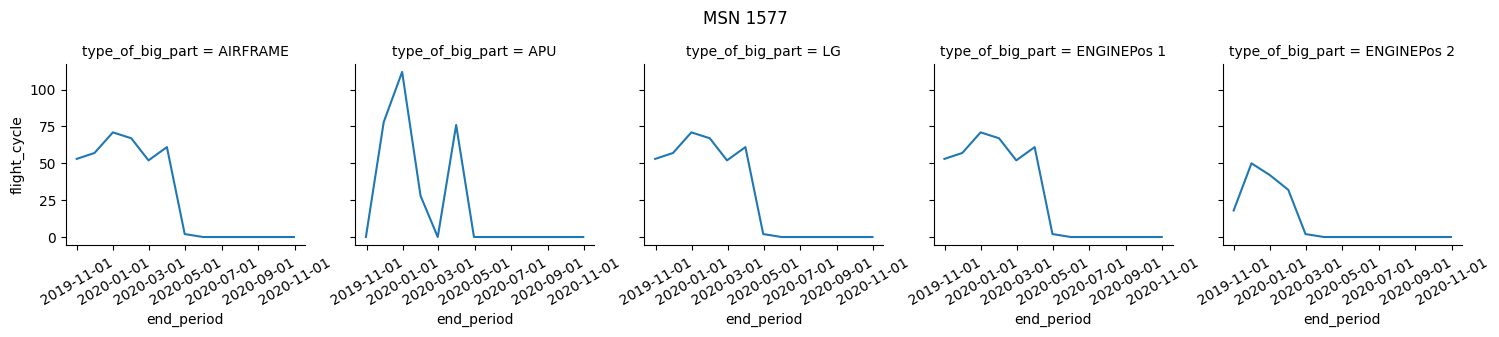

In [15]:
plot_sample_msn(act="Airbus 330-300")

As seen on the data, there's a big curve where the value of the flight cycle is approaching and is zero ranging from `2020-03` to `2020-11`. Some big parts have observations on that date range, but the majority seems to have no data in that range.

Also as expected, this approach only works for aircraft types that has a lot of aircrafts, but not so much for aircraft types that has little to no aircrafts available, for example `Airbus 330-200`.

Let's try another approach. Instead of taking the data from the perspective of each aircraft type, we can try taking the data by aggregating on each big part.

In [16]:
df_usage["type_of_big_part"].unique()

array(['AIRFRAME', 'ENGINEPos 1', 'ENGINEPos 2', 'APU', 'LG', 'PROPELLER',
       'N-LG', 'RH-LG', 'LH-LG'], dtype=object)

In [17]:
df_temp = df_usage.groupby(by=["type_of_big_part", "msn"]).count()["flight_cycle"].to_frame()
df_temp = df_temp.reset_index()
df_temp = df_temp.groupby(["type_of_big_part"]).max()["flight_cycle"].to_frame().reset_index()
df_temp.columns = ["type_of_big_part", "num_of_data"]
df_temp

,type_of_big_part,num_of_data
0,AIRFRAME,14
1,APU,14
2,ENGINEPos 1,14
3,ENGINEPos 2,14
4,LG,14
5,LH-LG,12
6,N-LG,12
7,PROPELLER,12
8,RH-LG,12


Overall, we have at least 12 data for each big parts. Let's see if their distribution is feasible for an aggregation. We need to check it for each data points that we have, meaning that we need to see the distribution for each time point ranging from `2019-09` to `2020-10`. Looking at all of those data points would be very difficult to do, so let's just sample data from some time periods.

In [18]:
def plot_sample_tp(time_period=None, n=3) :
  if not time_period :
    time_periods = np.random.choice(df_usage["end_period"].unique(), size=n)
  for time_period in time_periods :
    data = df_usage.loc[df_usage["end_period"] == time_period]
    grid = sns.FacetGrid(data, col="type_of_big_part")
    grid.map(sns.histplot, "flight_cycle")
    plt.subplots_adjust(top=.8)
    grid.fig.suptitle(f"end_period {time_period}")

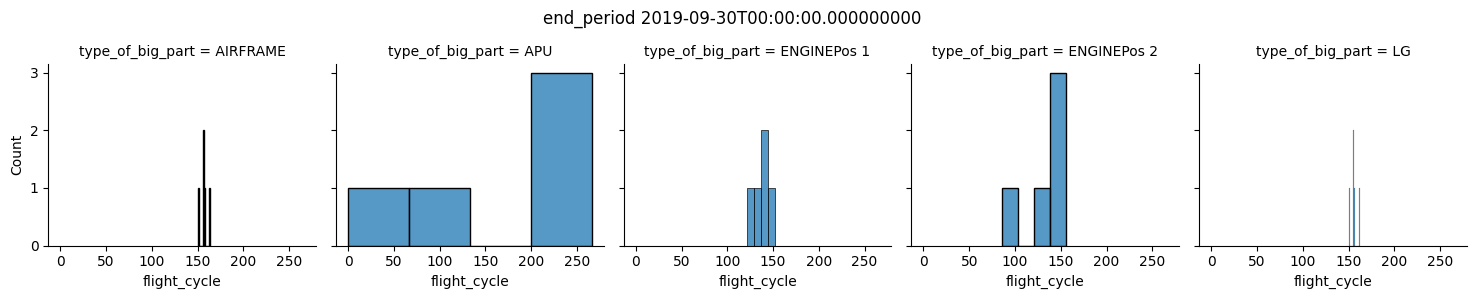

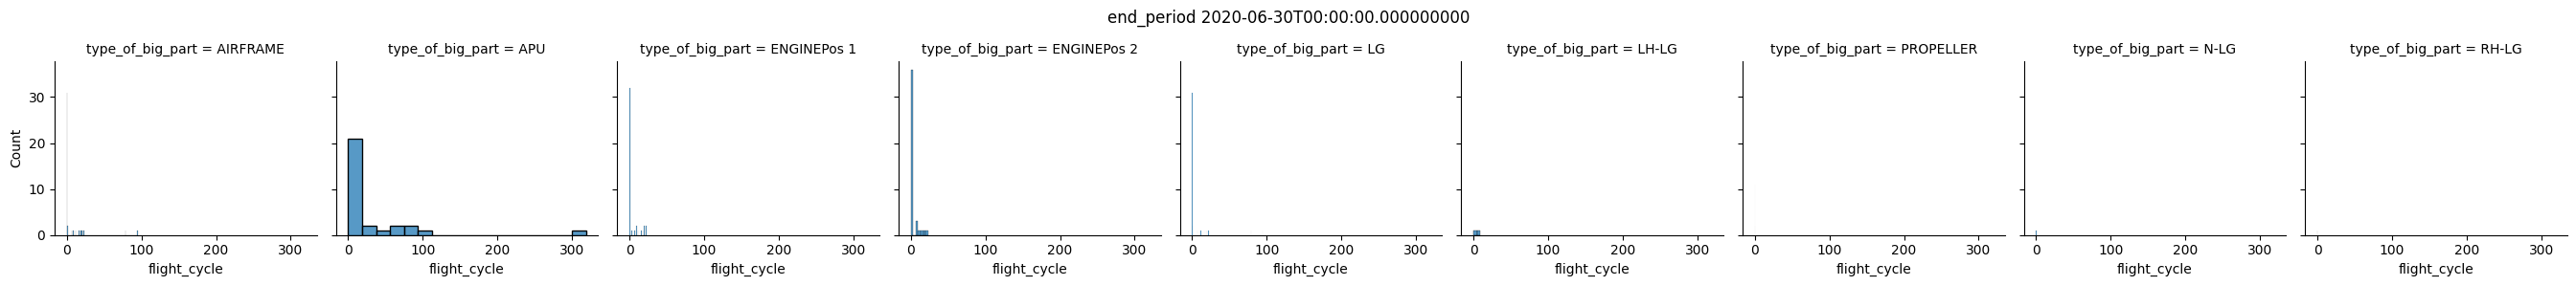

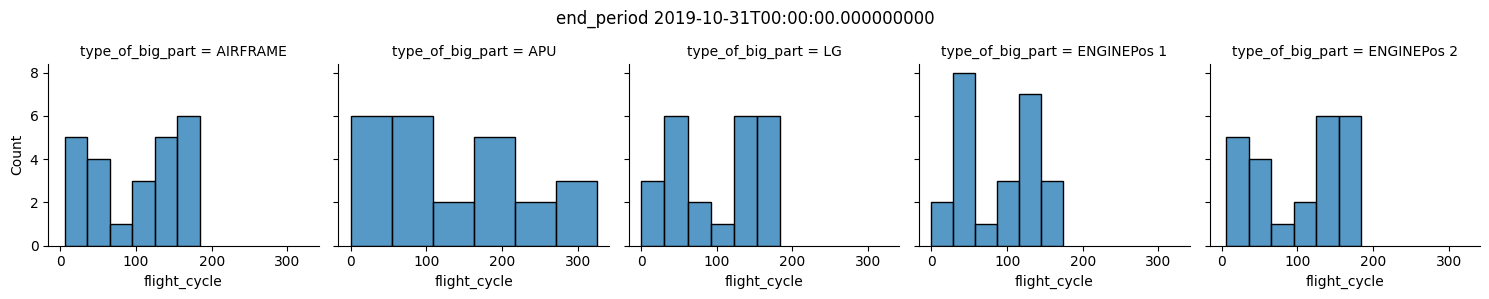

In [19]:
plot_sample_tp()

With data distributions like this, data aggregation is out of the consideration.

For abundant data like this, an approach that we can do is to do deep learning on the available data that we have to learn patterns from the series. By using artificial neural network, we can build a deep learning model with two layers of long short-term memory units.

LSTM is designed to learn patterns that depends on sequences, like time series, words in sentences, etc.

Our LSTM model need to be trained on each flight hour and flight cycle values, meaning that we will have two models, each for flight hour model and flight cycle model.

However, with this approach, we need the data to be sequentially sufficient, meaning that it should have no missing data in between the existing observations, which in the case of our data, we do have.

We will fix this problem by using imputation.

### Imputation of Missing Values

Firstly, we need to pick `big-part` and `msn` grouping that is at least viable and can be used for training. Let's set our threshold to at least 6 data points and see what we have.

In [20]:
timeframe = pd.DataFrame(df_usage["end_period"].unique(), columns=["end_period"]).sort_values(by="end_period").reset_index()

c_msn = []
c_bp = []

for msn in df_usage["msn"].unique() :
  cf = df_usage.loc[df_usage["msn"] == msn]
  for big_part in cf["type_of_big_part"].unique() :
    chk = cf.loc[cf["type_of_big_part"] == big_part]
    if len(chk) >= 6 :
      c_msn.append(msn)
      c_bp.append(big_part)
viable = pd.DataFrame(data={
  "msn": c_msn,
  "big_part": c_bp
})
viable.sample(10)

,msn,big_part
109,1249,LG
54,1152,LG
182,1254,AIRFRAME
214,1398,ENGINEPos 1
116,41806,AIRFRAME
174,1132,LG
52,1152,ENGINEPos 1
197,19031,LG
186,1254,PROPELLER
166,19032,AIRFRAME


Now that we have some samples on our hand, we're going to define a function to help us get the set with proper timestamps. Here is the function below.

In [21]:
def form_set(msn, big_part) :
  data = df_usage.loc[(df_usage["msn"] == msn) & (df_usage["type_of_big_part"] == big_part)]
  data = timeframe.merge(right=data, how="left", left_on="end_period", right_on="end_period")[["end_period","type_of_big_part","msn","flight_cycle","flight_hour"]]
  data["end_period"] = data["end_period"].values.astype("datetime64[D]")
  return data

In [22]:
form_set(19039, "ENGINEPos 2")

,end_period,type_of_big_part,msn,flight_cycle,flight_hour
0,2019-09-30,NaN,NaN,NaN,NaN
1,2019-10-31,NaN,NaN,NaN,NaN
2,2019-11-30,ENGINEPos 2,19039.0,133.0,120.100000
3,2019-12-31,ENGINEPos 2,19039.0,160.0,172.300000
4,2020-01-31,ENGINEPos 2,19039.0,154.0,188.783333
5,2020-02-29,ENGINEPos 2,19039.0,138.0,131.283333
6,2020-03-31,ENGINEPos 2,19039.0,58.0,65.950000
7,2020-04-30,ENGINEPos 2,19039.0,17.0,25.516667
8,2020-05-31,ENGINEPos 2,19039.0,0.0,0.000000
9,2020-06-30,ENGINEPos 2,19039.0,0.0,0.000000


We see that there are missing values. Let's try imputing it using interpolation.

In [23]:
df_temp = form_set(19039, "ENGINEPos 2")
df_temp["flight_cycle"] = df_temp["flight_cycle"].interpolate(method="spline", order=2, limit_direction="both", limit=10)
df_temp["flight_hour"] = df_temp["flight_hour"].interpolate(method="spline", order=2, limit_direction="both", limit=10)
df_temp

,end_period,type_of_big_part,msn,flight_cycle,flight_hour
0,2019-09-30,NaN,NaN,-452.239862,3.909131
1,2019-10-31,NaN,NaN,-70.777915,63.389166
2,2019-11-30,ENGINEPos 2,19039.0,133.000000,120.100000
3,2019-12-31,ENGINEPos 2,19039.0,160.000000,172.300000
4,2020-01-31,ENGINEPos 2,19039.0,154.000000,188.783333
5,2020-02-29,ENGINEPos 2,19039.0,138.000000,131.283333
6,2020-03-31,ENGINEPos 2,19039.0,58.000000,65.950000
7,2020-04-30,ENGINEPos 2,19039.0,17.000000,25.516667
8,2020-05-31,ENGINEPos 2,19039.0,0.000000,0.000000
9,2020-06-30,ENGINEPos 2,19039.0,0.000000,0.000000


As seen on the interpolating results, the spline method over-interpolates below the expected output. A flight cycle and flight hour usage time should never be below 0. This helper function should help smoothing the process.

In [24]:
def interp(df) :
  df["flight_cycle"] = df["flight_cycle"].interpolate(method="spline", order=2, limit_direction="both", limit=10, s=30)
  df["flight_hour"] = df["flight_hour"].interpolate(method="spline", order=2, limit_direction="both", limit=10, s=30)
  df.loc[df["flight_cycle"] < 0, "flight_cycle"] = 0
  df.loc[df["flight_hour"] < 0, "flight_hour"] = 0
  return df

After defining the custom interpolate function, we need to modify our `form_set` function, so that the data we get is complete. Here is the modified function.

In [25]:
def form_set(msn, big_part, interpolate=True) :
  data = df_usage.loc[(df_usage["msn"] == msn) & (df_usage["type_of_big_part"] == big_part)]
  data = timeframe.merge(right=data, how="left", left_on="end_period", right_on="end_period")[["end_period","type_of_big_part","msn","flight_cycle","flight_hour"]]
  data["end_period"] = data["end_period"].values.astype("datetime64[D]")
  if interpolate :
    warnings.filterwarnings("error")
    try :
      data = interp(data)
    except Warning as e :
      print(e)
      raise Exception(f"interp warning on {msn}-{big_part}")
  return data

In [26]:
df_temp = form_set(19039, "ENGINEPos 2")
df_temp

,end_period,type_of_big_part,msn,flight_cycle,flight_hour
0,2019-09-30,NaN,NaN,0.0,0.000000
1,2019-10-31,NaN,NaN,0.0,52.278570
2,2019-11-30,ENGINEPos 2,19039.0,133.0,120.100000
3,2019-12-31,ENGINEPos 2,19039.0,160.0,172.300000
4,2020-01-31,ENGINEPos 2,19039.0,154.0,188.783333
5,2020-02-29,ENGINEPos 2,19039.0,138.0,131.283333
6,2020-03-31,ENGINEPos 2,19039.0,58.0,65.950000
7,2020-04-30,ENGINEPos 2,19039.0,17.0,25.516667
8,2020-05-31,ENGINEPos 2,19039.0,0.0,0.000000
9,2020-06-30,ENGINEPos 2,19039.0,0.0,0.000000


## Convert the dataset into window format

After all that, we need to convert the dataset into a sliding time window format. To do that we're going to shift the values of each flight cycles and flight hours, and then make make the shifted value as our output for each sequence.

In [27]:
def pd_windowed_dataset(df, column_name, target_column_name, window_size) :
  df_result = df.copy()
  labels = []
  for i in range(1, window_size+1) :
    label = f"{column_name}_lag_{i}"
    labels.append(label)
    df_result.loc[:, label] = df[column_name].copy().shift(-i)
  df_result.columns = [column_name] + labels[:-1] + [target_column_name]
  return df_result.dropna()

# Example function usage (flight cycle)
print(f"{len(viable)} viable data of each group of [msn-big_part]")
ds_fc = None
i = 0
for _, row in viable.iterrows() :
  fs_i = form_set(row["msn"], row["big_part"])
  ds_fc_i = pd_windowed_dataset(fs_i[["flight_cycle"]], "flight_cycle", 'y', WINDOW_SIZE)
  if ds_fc is None :
    ds_fc = ds_fc_i
  else :
    ds_fc = pd.concat([ds_fc, ds_fc_i])
  i += len(fs_i)
print(f"Retrieved {len(ds_fc)} rows.")
ds_fc

218 viable data of each group of [msn-big_part]
Retrieved 2398 rows.


,flight_cycle,flight_cycle_lag_1,flight_cycle_lag_2,y
0,106.803638,87.0,98.0,131.0
1,87.000000,98.0,131.0,125.0
2,98.000000,131.0,125.0,91.0
3,131.000000,125.0,91.0,102.0
4,125.000000,91.0,102.0,16.0
...,...,...,...,...
6,0.000000,0.0,0.0,0.0
7,0.000000,0.0,0.0,0.0
8,0.000000,0.0,0.0,0.0
9,0.000000,0.0,0.0,0.0


We also have to split the data into test and training for validation later. For this task, we're going to split the data with ratio of 80:20, respectively for training and testing set. The function also has been modified a bit so that we can get everything regardless of the big part and msn, even though they're still being grouped by those criterias.

In [28]:
# Split dataset to training, val, and test set
def pd_split_dataset(df, validation_data_fraction, shuffle=False) :
  train_val_dataset, test_dataset = train_test_split(df, test_size=validation_data_fraction, shuffle=False)
  train_dataset, val_dataset = train_test_split(train_val_dataset, test_size=validation_data_fraction)
  # print("train", train_dataset)
  # print("val", val_dataset)
  # print("test", test_dataset)
  return train_dataset, val_dataset, test_dataset

# Example function usage (flight cycle)
fc_train, fc_val, fc_test = pd_split_dataset(ds_fc, validation_data_fraction=.1)
print(f"{len(fc_train)} rows for training set")
print(f"{len(fc_val)} rows for val set")
print(f"{len(fc_test)} rows for test set")
total_rows = len(fc_train)+len(fc_val)+len(fc_test)
print(f"{round((len(fc_train)/total_rows)*100, 2)}:{round((len(fc_val)/total_rows)*100, 2)}:{round((len(fc_test)/total_rows)*100, 2)}")

1942 rows for training set
216 rows for val set
240 rows for test set
80.98:9.01:10.01


One more thing we have to note here is that the model might get biased to 0 because of the pandemic that happened around `2020-03` to `2020-11`. We need to reduce the number of samples that has 0-valued `y` to prevent this.

In [29]:
# Resample zeroes on training set
def resample_zeros(df, target_column_name, frac=.1) :
  zdf = df.loc[df[target_column_name] == 0.]
  ndf = df.loc[df[target_column_name] != 0.]
  zdf = zdf.sample(frac=frac)
  return pd.concat([ndf, zdf])

# Example function usage (flight cycle)
fc_train = resample_zeros(fc_train, 'y', frac=.1)
print(len(fc_train))
fc_train

1052


,flight_cycle,flight_cycle_lag_1,flight_cycle_lag_2,y
1,0.000000,34.00000,66.0,14.0
1,38.000000,28.00000,41.0,32.0
0,73.506261,64.96539,58.0,56.0
1,0.000000,224.00000,229.0,42.0
6,166.000000,89.00000,0.0,73.0
...,...,...,...,...
2,81.000000,16.00000,0.0,0.0
4,0.000000,0.00000,0.0,0.0
6,0.000000,0.00000,0.0,0.0
5,68.000000,51.00000,4.0,0.0


To make it compatible with `tensorflow`, the deep learning framework we're going to use, we'll be using numpy array instead of `pandas` dataframe.

In [30]:
# Convert pandas dataframe to tensorflow dataset
def df2tds(df, target_column_name, buffer_size) :
  features = np.expand_dims(df.drop(columns=[target_column_name], axis=1).to_numpy(), axis=-1)
  target = np.expand_dims(df[target_column_name].to_numpy(), axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices((features, target))
  dataset = dataset.shuffle(buffer_size)
  return dataset

# Example function usage (flight cycle)
fc_train = df2tds(fc_train, 'y', 5000)
print(len(list(fc_train.as_numpy_iterator())))
list(fc_train.as_numpy_iterator())[:3]

1052


[(array([[50.],
         [48.],
         [16.]]),
  array([0.])),
 (array([[ 0.],
         [ 0.],
         [46.]]),
  array([56.])),
 (array([[135.],
         [132.],
         [141.]]),
  array([141.]))]

Combining all the functions defined above, we get a function that converts our viable `msn-big_part` data group into our training and testing dataset.

In [31]:
# Get all big parts into one dataset if no big_part is stated in the parameter
def pd_big_parts_window_dataset(df_viable, window_size, batch_size, shuffle_buffer_size, split=.1, big_part=None, resample_frac=.1) :
  if big_part is not None :
    df_viable = df_viable.loc[df_viable["big_part"] == big_part]
    print(f"Getting {big_part} big part data")
  else :
    print("Getting all big parts")
  ds_fc, ds_fh = None, None
  i = 0
  for _, row in df_viable.iterrows() :
    fs_i = form_set(row["msn"], row["big_part"])
    ds_fc_i = pd_windowed_dataset(fs_i[["flight_cycle"]], "flight_cycle", 'y', window_size)
    ds_fh_i = pd_windowed_dataset(fs_i[["flight_hour"]], "flight_hour", 'y', window_size)
    if ds_fc is None :
      ds_fc = ds_fc_i
    else :
      ds_fc = pd.concat([ds_fc, ds_fc_i])
    if ds_fh is None :
      ds_fh = ds_fh_i
    else :
      ds_fh = pd.concat([ds_fh, ds_fh_i])
    i += len(fs_i)
  print(f"Retrieved {i} rows.")
  # Split to training, validation, and test set
  fc_train, fc_val, fc_test = pd_split_dataset(ds_fc, validation_data_fraction=split)
  fh_train, fh_val, fh_test = pd_split_dataset(ds_fh, validation_data_fraction=split)

  # Only resample zeroes on training set
  fc_train = resample_zeros(fc_train, 'y', frac=resample_frac)
  fh_train = resample_zeros(fh_train, 'y', frac=resample_frac)

  # Convert pandas dataframe to tensor data slices
  fc_train = df2tds(fc_train, 'y', shuffle_buffer_size)
  fc_val = df2tds(fc_val, 'y', shuffle_buffer_size)
  fc_test = df2tds(fc_test, 'y', shuffle_buffer_size)

  fh_train = df2tds(fh_train, 'y', shuffle_buffer_size)
  fh_val = df2tds(fh_val, 'y', shuffle_buffer_size)
  fh_test = df2tds(fh_test, 'y', shuffle_buffer_size)

  print(fc_train.batch(batch_size))

  return (
    fc_train.batch(batch_size).prefetch(1),
    fc_val.batch(batch_size).prefetch(1),
    fc_test.batch(batch_size).prefetch(1),
    fh_train.batch(batch_size).prefetch(1),
    fh_val.batch(batch_size).prefetch(1),
    fh_test.batch(batch_size).prefetch(1),
  )

fc_train, fc_val, fc_test, fh_train, fh_val, fh_test = pd_big_parts_window_dataset(
  viable,
  window_size=WINDOW_SIZE,
  batch_size=BATCH_SIZE,
  shuffle_buffer_size=BUFFER_SIZE
)

Getting all big parts
Retrieved 3052 rows.
<_BatchDataset element_spec=(TensorSpec(shape=(None, 3, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


## Modelling

Let's build the model! The structure of model we're going to be using can be seen in the code below. It is a relatively simple model that consists of a 1-dimensional convolutional unit, 2 hidden RNN/LSTM/GRU layers, 2 hidden dense layers, and an output layer that predicts the flight cycle and flight hour value.

We will need to train two models for each RNN, LSTM, and GRU unit type; for predicting flight cycle, and flight hour. All models will be trained on every big parts dataset, regardless of `msn` (though the sequences will be grouped by `msn`). This is the simplest and quickest way to provide a flight cycle and flight hour forecast. Let's see if the model works efficiently or not.

### General flight cycle model

#### LSTM

In [32]:
def general_fc_lstm_model_builder() :
  tf.keras.backend.clear_session()
  tf.random.set_seed(5200)
  np.random.seed(5200)
  return tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(
      filters=64, kernel_size=3,
      strides=1, padding="causal",
      activation="relu", input_shape=[WINDOW_SIZE, 1]
    ),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
  ])
general_fc_lstm_model = general_fc_lstm_model_builder()
general_fc_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 64)             256       
                                                                 
 lstm (LSTM)                 (None, 3, 64)             33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 68,575
Trainable params: 68,575
Non-traina

#### GRU

In [33]:
def general_fc_gru_model_builder() :
  tf.keras.backend.clear_session()
  tf.random.set_seed(5200)
  np.random.seed(5200)
  return tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(
      filters=64, kernel_size=3,
      strides=1, padding="causal",
      activation="relu", input_shape=[WINDOW_SIZE, 1]
    ),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
  ])
general_fc_gru_model = general_fc_gru_model_builder()
general_fc_gru_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 64)             256       
                                                                 
 gru (GRU)                   (None, 3, 64)             24960     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 52,447
Trainable params: 52,447
Non-traina

#### RNN

To use RNN, we must manually define our RNN cell. Here's the definition of the cell and the model.

In [34]:
class CustomRNNCell(tf.keras.layers.Layer) :
  def __init__(self, units) :
    super(CustomRNNCell, self).__init__()
    self.units = units
    self.state_size = units
  
  def build(self, input_shape) :
    self.kernel = self.add_weight(
      shape=(input_shape[-1], self.units),
      initializer="uniform",
      name="kernel"
    )
    self.recurrent_kernel = self.add_weight(
      shape=(self.units, self.units),
      initializer="uniform",
      name="recurrent_kernel"
    )
    self.built = True
  
  def call(self, inputs, states) :
    prev_output = states[0]
    h = tf.keras.backend.dot(inputs, self.kernel)
    output = h + tf.keras.backend.dot(prev_output, self.recurrent_kernel)
    return output, [output]

def general_fc_rnn_model_builder() :
  tf.keras.backend.clear_session()
  tf.random.set_seed(5200)
  np.random.seed(5200)
  cells = [CustomRNNCell(64), CustomRNNCell(64)]
  return tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(
      filters=64, kernel_size=3,
      strides=1, padding="causal",
      activation="relu", input_shape=[WINDOW_SIZE, 1]
    ),
    tf.keras.layers.RNN(cells[0], return_sequences=True),
    tf.keras.layers.RNN(cells[1]),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
  ])
general_fc_rnn_model = general_fc_rnn_model_builder()
general_fc_rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 64)             256       
                                                                 
 rnn (RNN)                   (None, 3, 64)             8192      
                                                                 
 rnn_1 (RNN)                 (None, 64)                8192      
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 18,911
Trainable params: 18,911
Non-traina

### General flight hour model

There shouldn't be any difference between flight cycle model and flight hour model. Let's begin defining our general flight hour models.

#### LSTM

In [35]:
def general_fh_lstm_model_builder() :
  tf.keras.backend.clear_session()
  tf.random.set_seed(5200)
  np.random.seed(5200)
  return tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(
      filters=64, kernel_size=3,
      strides=1, padding="causal",
      activation="relu", input_shape=[WINDOW_SIZE, 1]
    ),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
  ])
general_fh_lstm_model = general_fh_lstm_model_builder()
general_fh_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 64)             256       
                                                                 
 lstm (LSTM)                 (None, 3, 64)             33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 68,575
Trainable params: 68,575
Non-traina

#### GRU

In [36]:
def general_fh_gru_model_builder() :
  tf.keras.backend.clear_session()
  tf.random.set_seed(5200)
  np.random.seed(5200)
  return tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(
      filters=64, kernel_size=3,
      strides=1, padding="causal",
      activation="relu", input_shape=[WINDOW_SIZE, 1]
    ),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
  ])
general_fh_gru_model = general_fh_gru_model_builder()
general_fh_gru_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 64)             256       
                                                                 
 gru (GRU)                   (None, 3, 64)             24960     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 52,447
Trainable params: 52,447
Non-traina

#### RNN

In [37]:
def general_fh_rnn_model_builder() :
  tf.keras.backend.clear_session()
  tf.random.set_seed(5200)
  np.random.seed(5200)
  cells = [CustomRNNCell(64), CustomRNNCell(64)]
  return tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(
      filters=64, kernel_size=3,
      strides=1, padding="causal",
      activation="relu", input_shape=[WINDOW_SIZE, 1]
    ),
    tf.keras.layers.RNN(cells[0], return_sequences=True),
    tf.keras.layers.RNN(cells[1]),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
  ])
general_fh_rnn_model = general_fh_rnn_model_builder()
general_fh_rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 64)             256       
                                                                 
 rnn (RNN)                   (None, 3, 64)             8192      
                                                                 
 rnn_1 (RNN)                 (None, 64)                8192      
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 18,911
Trainable params: 18,911
Non-traina

## Training scripts

Now that we have defined our LSTM/GRU/RNN flight cycle and flight hour model, we're going to create helper functions to train our models.

In [38]:
# To search for optimal learning rate
def run_scheduled_lr(train_set, model:tf.keras.models.Sequential, lr_func, lr_start, epochs, verbose=0) :
  tf.keras.backend.clear_session()
  tf.random.set_seed(5200)
  np.random.seed(5200)
  lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: lr_func(epoch)
  )
  optimizer = tf.keras.optimizers.SGD(
    learning_rate=lr_start,
    momentum=.9
  )
  model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.Huber(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
  )
  history = model.fit(
    train_set,
    epochs=epochs,
    callbacks=[lr_schedule],
    verbose=verbose
  )
  print("Done training")
  plt.semilogx(history.history["lr"], history.history["loss"])
  return history

# To train model
def run_fit(train_set, val_set, model:tf.keras.models.Sequential, lr, epochs, verbose=0) :
  tf.keras.backend.clear_session()
  tf.random.set_seed(5200)
  np.random.seed(5200)
  optimizer = tf.keras.optimizers.SGD(
    learning_rate=lr,
    momentum=.9
  )
  model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.Huber(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
  )
  history = model.fit(
    train_set,
    epochs=epochs,
    validation_data=val_set,
    verbose=verbose
  )
  rmse = history.history["root_mean_squared_error"]
  val_rmse = history.history["val_root_mean_squared_error"]
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  plt.figure(figsize=(10,5))
  epochs = range(len(rmse))

  plt.subplot(1,2,1)
  plt.plot(epochs, rmse, 'r', label="Training RMSE")
  plt.plot(epochs, val_rmse, 'b', label="Validation RMSE")
  plt.xlabel("Epoch")
  plt.legend(["train", "val"])
  plt.title("Training and Validation set RMSEs")

  plt.subplot(1,2,2)
  plt.plot(epochs, loss, 'r', label="Training Loss")
  plt.plot(epochs, val_loss, 'b', label="Validation Loss")
  plt.xlabel("Epoch")
  plt.legend(["train", "val"])
  plt.title("Training and Validation set losses")

  plt.show()
  return model, history

Let's define the flight cycle and flight hour train and test set, and the learning rate scheduler function to set the learning rate value throughout the training process.

In [39]:
tf.keras.backend.clear_session()
tf.random.set_seed(5200)
np.random.seed(5200)

fc_train, fc_val, fc_test, fh_train, fh_val, fh_test = pd_big_parts_window_dataset(
  viable,
  window_size=WINDOW_SIZE,
  batch_size=BATCH_SIZE,
  shuffle_buffer_size=BUFFER_SIZE
)

def general_fc_lr_func(epoch) :
  return LR_START + ((epoch/20) * .001)

def general_fh_lr_func(epoch) :
  return LR_START + ((epoch/20) * .001)

Getting all big parts
Retrieved 3052 rows.
<_BatchDataset element_spec=(TensorSpec(shape=(None, 3, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


Now, let's try to optimize the learning rate for each model first.

### General flight cycle model

#### LSTM

Done training


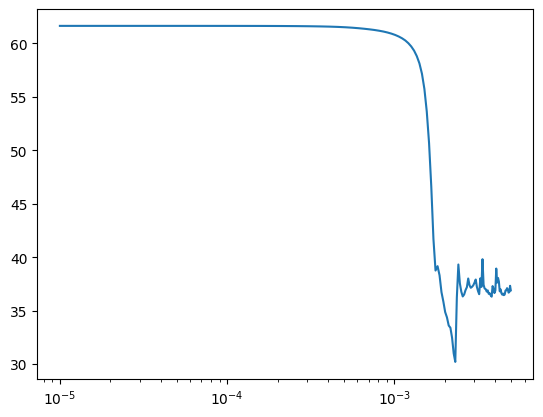

In [40]:
history = run_scheduled_lr(fc_train, general_fc_lstm_model, general_fc_lr_func, LR_START, EPOCHS)

After getting the losses for each epoch, we're going to pick the learning rate of the epoch with the minimum loss value, and then train the model using that learning rate.

using 0.002309999894350767 as learning rate for general_fc_lstm model


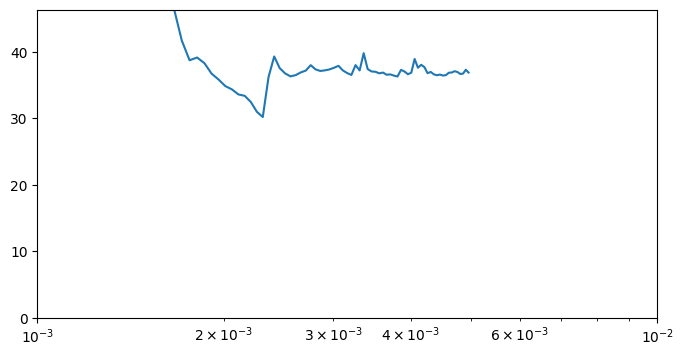

In [41]:
lr_list = history.history["lr"]
loss_list = history.history["loss"]
fig = plt.figure(figsize=(8,4))
plt.semilogx(lr_list, loss_list)
plt.axis([1e-3, 1e-2, 0, max(loss_list)/1.33])
general_fc_lstm_lr = lr_list[loss_list.index(min(loss_list))]
print(f"using {general_fc_lstm_lr} as learning rate for general_fc_lstm model")

Epoch 1/100
4/4 [==============================] - 2s 150ms/step - loss: 61.4895 - root_mean_squared_error: 82.0349 - val_loss: 35.1608 - val_root_mean_squared_error: 60.2655
Epoch 2/100
4/4 [==============================] - 0s 15ms/step - loss: 61.1455 - root_mean_squared_error: 81.7143 - val_loss: 34.9180 - val_root_mean_squared_error: 59.8889
Epoch 3/100
4/4 [==============================] - 0s 15ms/step - loss: 60.5613 - root_mean_squared_error: 81.1555 - val_loss: 34.6343 - val_root_mean_squared_error: 59.3383
Epoch 4/100
4/4 [==============================] - 0s 15ms/step - loss: 59.7589 - root_mean_squared_error: 80.3779 - val_loss: 34.3122 - val_root_mean_squared_error: 58.5881
Epoch 5/100
4/4 [==============================] - 0s 14ms/step - loss: 58.7015 - root_mean_squared_error: 79.2814 - val_loss: 33.8450 - val_root_mean_squared_error: 57.4766
Epoch 6/100
4/4 [==============================] - 0s 14ms/step - loss: 57.0408 - root_mean_squared_error: 77.5765 - val_loss: 33

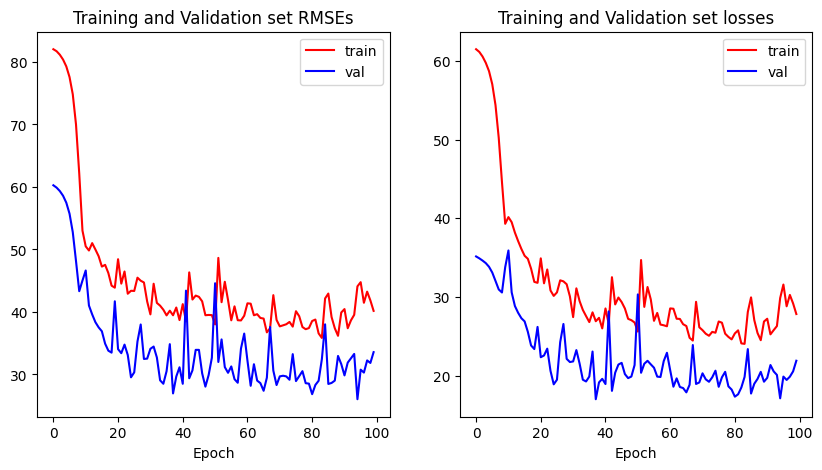

In [42]:
tf.keras.backend.clear_session()
tf.random.set_seed(5200)
np.random.seed(5200)

general_fc_lstm_model = general_fc_lstm_model_builder()
general_fc_lstm_model, fc_lstm_history = run_fit(fc_train, fc_test, general_fc_lstm_model, general_fc_lstm_lr, EPOCHS, verbose=1)

#### GRU

Done training


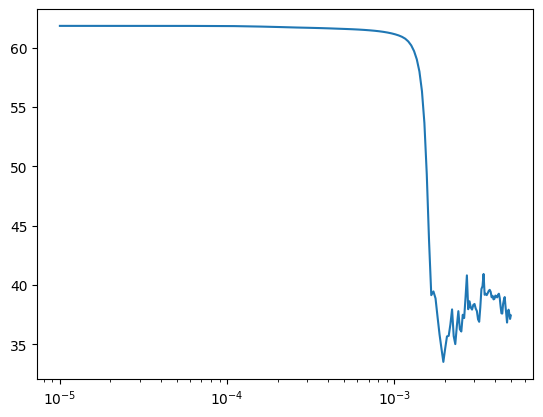

In [43]:
history = run_scheduled_lr(fc_train, general_fc_gru_model, general_fc_lr_func, LR_START, EPOCHS)

using 0.0019600000232458115 as learning rate for general_fc_gru model


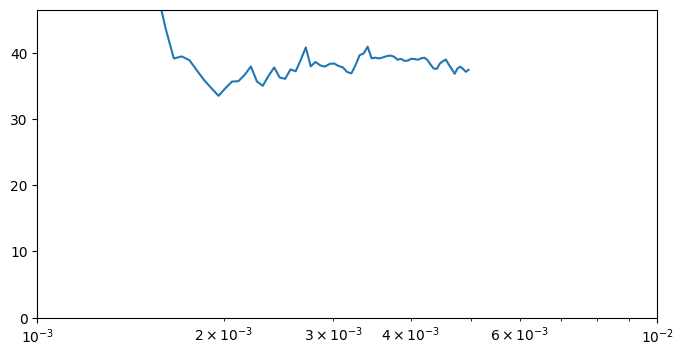

In [44]:
lr_list = history.history["lr"]
loss_list = history.history["loss"]
fig = plt.figure(figsize=(8,4))
plt.semilogx(lr_list, loss_list)
plt.axis([1e-3, 1e-2, 0, max(loss_list)/1.33])
general_fc_gru_lr = lr_list[loss_list.index(min(loss_list))]
print(f"using {general_fc_gru_lr} as learning rate for general_fc_gru model")

Epoch 1/100
4/4 [==============================] - 2s 126ms/step - loss: 61.3394 - root_mean_squared_error: 81.8955 - val_loss: 34.9090 - val_root_mean_squared_error: 59.8947
Epoch 2/100
4/4 [==============================] - 0s 13ms/step - loss: 60.5176 - root_mean_squared_error: 81.1050 - val_loss: 34.4750 - val_root_mean_squared_error: 59.1592
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 59.3985 - root_mean_squared_error: 80.0088 - val_loss: 33.8222 - val_root_mean_squared_error: 57.9391
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 57.4917 - root_mean_squared_error: 78.0538 - val_loss: 32.6270 - val_root_mean_squared_error: 55.6277
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 53.9967 - root_mean_squared_error: 74.4085 - val_loss: 30.9672 - val_root_mean_squared_error: 51.6991
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 48.5272 - root_mean_squared_error: 67.9552 - val_loss: 29

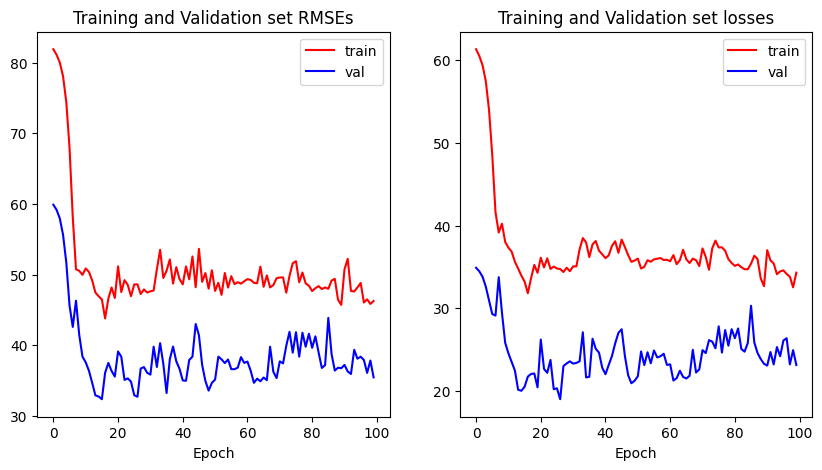

In [45]:
tf.keras.backend.clear_session()
tf.random.set_seed(5200)
np.random.seed(5200)

general_fc_gru_model = general_fc_gru_model_builder()
general_fc_gru_model, fc_gru_history = run_fit(fc_train, fc_test, general_fc_gru_model, general_fc_gru_lr, EPOCHS, verbose=1)

#### RNN

Done training


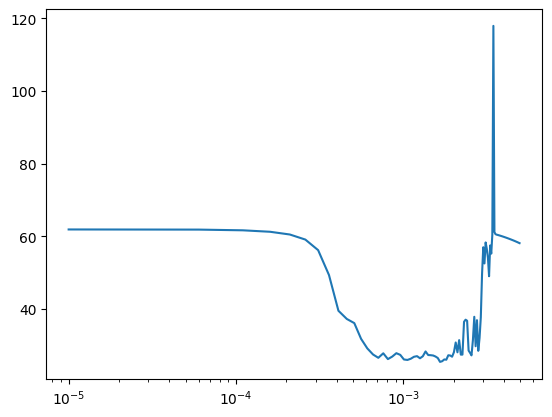

In [46]:
history = run_scheduled_lr(fc_train, general_fc_rnn_model, general_fc_lr_func, LR_START, EPOCHS)

using 0.0016599999507889152 as learning rate for general_fc_rnn model


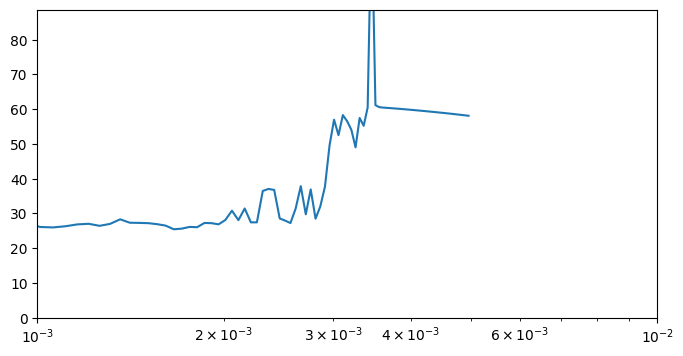

In [47]:
lr_list = history.history["lr"]
loss_list = history.history["loss"]
fig = plt.figure(figsize=(8,4))
plt.semilogx(lr_list, loss_list)
plt.axis([1e-3, 1e-2, 0, max(loss_list)/1.33])
general_fc_rnn_lr = lr_list[loss_list.index(min(loss_list))]
print(f"using {general_fc_rnn_lr} as learning rate for general_fc_rnn model")

Epoch 1/100
4/4 [==============================] - 1s 59ms/step - loss: 59.2959 - root_mean_squared_error: 79.4361 - val_loss: 29.5481 - val_root_mean_squared_error: 50.8455
Epoch 2/100
4/4 [==============================] - 0s 10ms/step - loss: 42.0809 - root_mean_squared_error: 70.9490 - val_loss: 24.2730 - val_root_mean_squared_error: 39.6540
Epoch 3/100
4/4 [==============================] - 0s 8ms/step - loss: 34.7665 - root_mean_squared_error: 50.1948 - val_loss: 29.1032 - val_root_mean_squared_error: 51.0820
Epoch 4/100
4/4 [==============================] - 0s 8ms/step - loss: 48.4020 - root_mean_squared_error: 67.9446 - val_loss: 24.7388 - val_root_mean_squared_error: 43.4159
Epoch 5/100
4/4 [==============================] - 0s 9ms/step - loss: 42.0245 - root_mean_squared_error: 69.4027 - val_loss: 15.2328 - val_root_mean_squared_error: 25.6679
Epoch 6/100
4/4 [==============================] - 0s 8ms/step - loss: 29.5707 - root_mean_squared_error: 44.2032 - val_loss: 19.3276

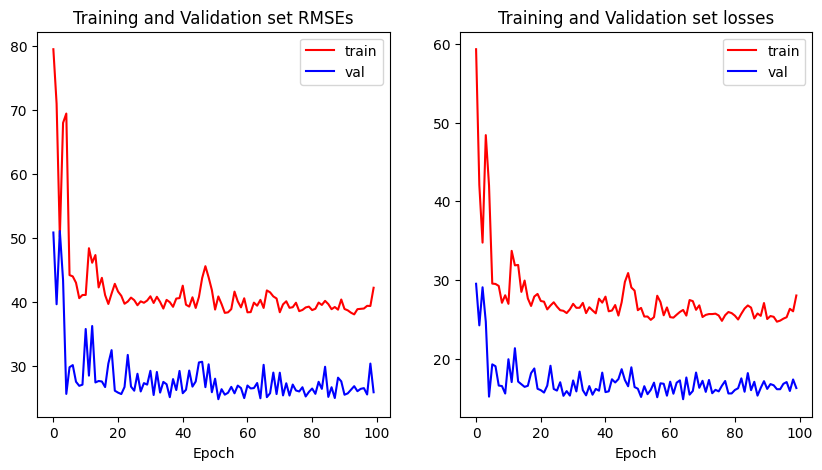

In [48]:
tf.keras.backend.clear_session()
tf.random.set_seed(5200)
np.random.seed(5200)

general_fc_rnn_model = general_fc_rnn_model_builder()
general_fc_rnn_model, fc_rnn_history = run_fit(fc_train, fc_test, general_fc_rnn_model, general_fc_rnn_lr, EPOCHS, verbose=1)

### General flight hour model

#### LSTM

Done training


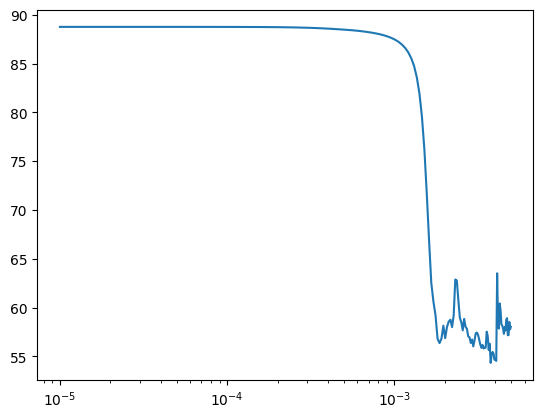

In [49]:
history = run_scheduled_lr(fh_train, general_fh_lstm_model, general_fh_lr_func, LR_START, EPOCHS)

using 0.003759999992325902 as learning rate for general_fh_lstm model


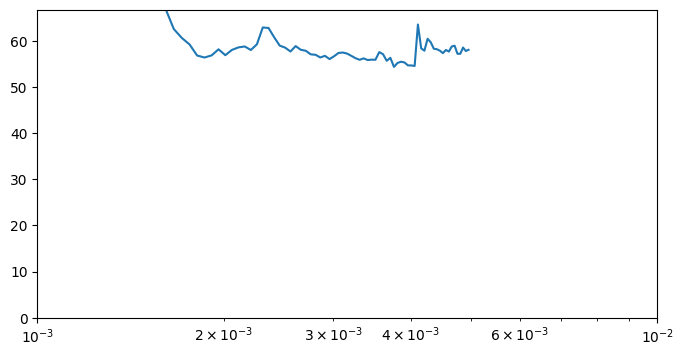

In [50]:
lr_list = history.history["lr"]
loss_list = history.history["loss"]
fig = plt.figure(figsize=(8,4))
plt.semilogx(lr_list, loss_list)
plt.axis([1e-3, 1e-2, 0, max(loss_list)/1.33])
general_fh_lstm_lr = lr_list[loss_list.index(min(loss_list))]
print(f"using {general_fh_lstm_lr} as learning rate for general_fh_lstm model")

Epoch 1/100
4/4 [==============================] - 3s 169ms/step - loss: 88.6987 - root_mean_squared_error: 123.5477 - val_loss: 38.4295 - val_root_mean_squared_error: 64.4068
Epoch 2/100
4/4 [==============================] - 0s 15ms/step - loss: 88.5135 - root_mean_squared_error: 123.3866 - val_loss: 38.2947 - val_root_mean_squared_error: 64.2216
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 88.2212 - root_mean_squared_error: 123.1304 - val_loss: 38.1375 - val_root_mean_squared_error: 63.9554
Epoch 4/100
4/4 [==============================] - 0s 14ms/step - loss: 87.8262 - root_mean_squared_error: 122.7870 - val_loss: 37.9726 - val_root_mean_squared_error: 63.5821
Epoch 5/100
4/4 [==============================] - 0s 14ms/step - loss: 87.2651 - root_mean_squared_error: 122.2784 - val_loss: 37.7550 - val_root_mean_squared_error: 63.0051
Epoch 6/100
4/4 [==============================] - 0s 14ms/step - loss: 86.3814 - root_mean_squared_error: 121.4529 - val_lo

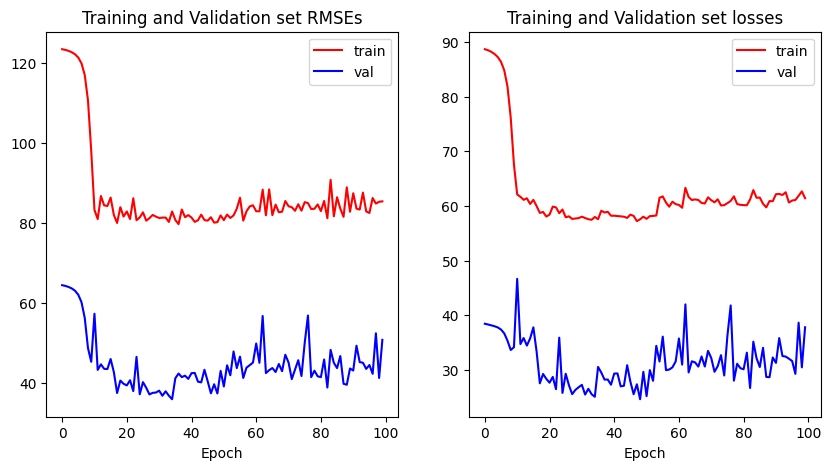

In [51]:
tf.keras.backend.clear_session()
tf.random.set_seed(5200)
np.random.seed(5200)

general_fh_lstm_model = general_fh_lstm_model_builder()
general_fh_lstm_model, fh_lstm_history = run_fit(fh_train, fh_test, general_fh_lstm_model, general_fh_lstm_lr, EPOCHS, verbose=1)

#### GRU

Done training


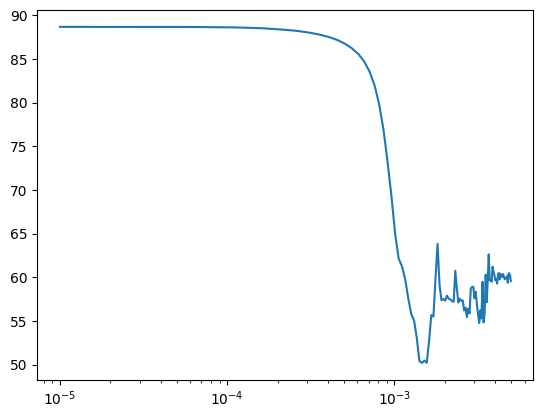

In [52]:
history = run_scheduled_lr(fh_train, general_fh_gru_model, general_fh_lr_func, LR_START, EPOCHS)

using 0.0014600000577047467 as learning rate for general_fh_gru model


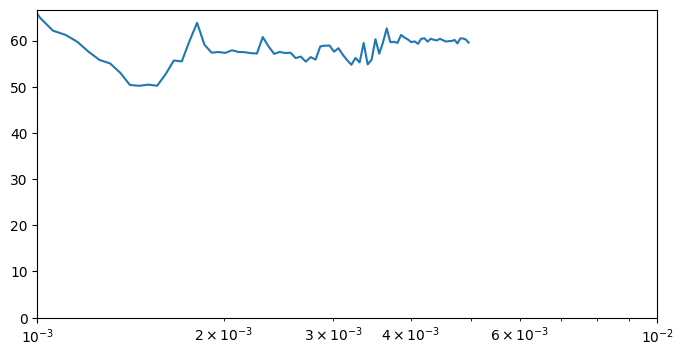

In [53]:
lr_list = history.history["lr"]
loss_list = history.history["loss"]
fig = plt.figure(figsize=(8,4))
plt.semilogx(lr_list, loss_list)
plt.axis([1e-3, 1e-2, 0, max(loss_list)/1.33])
general_fh_gru_lr = lr_list[loss_list.index(min(loss_list))]
print(f"using {general_fh_gru_lr} as learning rate for general_fh_gru model")

Epoch 1/100
4/4 [==============================] - 2s 137ms/step - loss: 88.4252 - root_mean_squared_error: 123.2634 - val_loss: 38.1851 - val_root_mean_squared_error: 64.0488
Epoch 2/100
4/4 [==============================] - 0s 13ms/step - loss: 87.9399 - root_mean_squared_error: 122.8437 - val_loss: 37.8862 - val_root_mean_squared_error: 63.5613
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 87.2874 - root_mean_squared_error: 122.2478 - val_loss: 37.5592 - val_root_mean_squared_error: 62.9658
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 86.4149 - root_mean_squared_error: 121.4422 - val_loss: 37.0927 - val_root_mean_squared_error: 62.0806
Epoch 5/100
4/4 [==============================] - 0s 14ms/step - loss: 85.1501 - root_mean_squared_error: 120.2467 - val_loss: 36.4299 - val_root_mean_squared_error: 60.7068
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 83.1637 - root_mean_squared_error: 118.3303 - val_lo

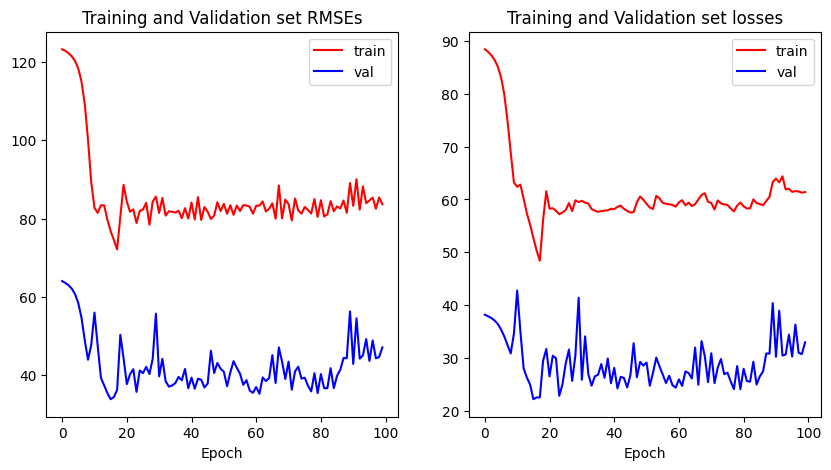

In [54]:
tf.keras.backend.clear_session()
tf.random.set_seed(5200)
np.random.seed(5200)

general_fh_gru_model = general_fh_gru_model_builder()
general_fh_gru_model, fh_gru_history = run_fit(fh_train, fh_test, general_fh_gru_model, general_fh_gru_lr, EPOCHS, verbose=1)

#### RNN

Done training


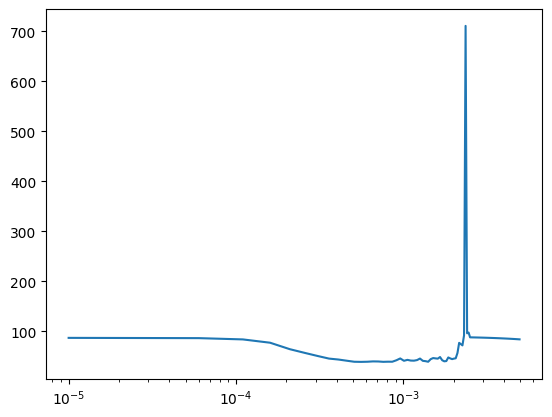

In [55]:
history = run_scheduled_lr(fh_train, general_fh_rnn_model, general_fh_lr_func, LR_START, EPOCHS)

using 0.0005600000149570405 as learning rate for general_fh_rnn model


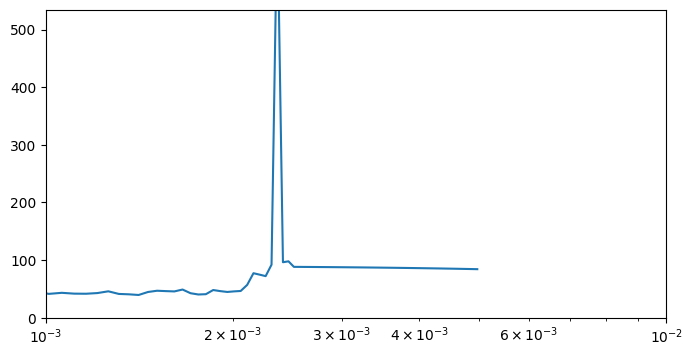

In [56]:
lr_list = history.history["lr"]
loss_list = history.history["loss"]
fig = plt.figure(figsize=(8,4))
plt.semilogx(lr_list, loss_list)
plt.axis([1e-3, 1e-2, 0, max(loss_list)/1.33])
general_fh_rnn_lr = lr_list[loss_list.index(min(loss_list))]
print(f"using {general_fh_rnn_lr} as learning rate for general_fh_rnn model")

Epoch 1/100
4/4 [==============================] - 1s 57ms/step - loss: 87.8213 - root_mean_squared_error: 122.5184 - val_loss: 37.3710 - val_root_mean_squared_error: 62.8004
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 83.5825 - root_mean_squared_error: 117.6686 - val_loss: 33.5185 - val_root_mean_squared_error: 56.5391
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 67.1668 - root_mean_squared_error: 96.3750 - val_loss: 34.6885 - val_root_mean_squared_error: 79.5958
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 61.1037 - root_mean_squared_error: 106.3027 - val_loss: 26.8697 - val_root_mean_squared_error: 45.8491
Epoch 5/100
4/4 [==============================] - 0s 9ms/step - loss: 61.8010 - root_mean_squared_error: 88.1147 - val_loss: 22.9082 - val_root_mean_squared_error: 37.9895
Epoch 6/100
4/4 [==============================] - 0s 8ms/step - loss: 49.3655 - root_mean_squared_error: 77.3820 - val_loss: 21.

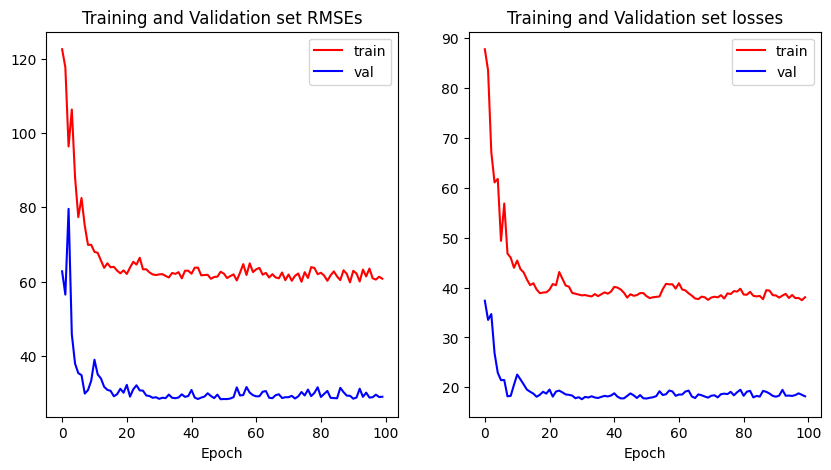

In [57]:
tf.keras.backend.clear_session()
tf.random.set_seed(5200)
np.random.seed(5200)

general_fh_rnn_model = general_fh_rnn_model_builder()
general_fh_rnn_model, fh_rnn_history = run_fit(fh_train, fh_test, general_fh_rnn_model, general_fh_rnn_lr, EPOCHS, verbose=1)

## Model evaluation

Next, we're going to evaluate our models for each flight cycle and flight hour dataset with our test set. The metric we're using to compare all the models is RMSE.

### General flight cycle models

#### LSTM

In [58]:
results = general_fc_lstm_model.evaluate(fc_test, batch_size=BATCH_SIZE)
print(f"test loss, test rmse: {results}")

1/1 [==============================] - 0s 145ms/step - loss: 21.9097 - root_mean_squared_error: 33.5634
test loss, test rmse: [21.90970802307129, 33.56339645385742]


#### GRU

In [59]:
results = general_fc_gru_model.evaluate(fc_test, batch_size=BATCH_SIZE)
print(f"test loss, test rmse: {results}")

1/1 [==============================] - 0s 149ms/step - loss: 23.1437 - root_mean_squared_error: 35.4613
test loss, test rmse: [23.143749237060547, 35.4613037109375]


#### RNN

In [60]:
results = general_fc_rnn_model.evaluate(fc_test, batch_size=BATCH_SIZE)
print(f"test loss, test rmse: {results}")

1/1 [==============================] - 0s 73ms/step - loss: 16.3242 - root_mean_squared_error: 25.9264
test loss, test rmse: [16.324243545532227, 25.926362991333008]


### General flight hour models

#### LSTM

In [61]:
results = general_fh_lstm_model.evaluate(fh_test, batch_size=BATCH_SIZE)
print(f"test loss, test rmse: {results}")

1/1 [==============================] - 0s 152ms/step - loss: 37.7849 - root_mean_squared_error: 50.6976
test loss, test rmse: [37.7849235534668, 50.697566986083984]


#### GRU

In [62]:
results = general_fh_gru_model.evaluate(fh_test, batch_size=BATCH_SIZE)
print(f"test loss, test rmse: {results}")

1/1 [==============================] - 0s 148ms/step - loss: 32.9490 - root_mean_squared_error: 47.1150
test loss, test rmse: [32.94896697998047, 47.11504364013672]


#### RNN

In [63]:
results = general_fh_rnn_model.evaluate(fh_test, batch_size=BATCH_SIZE)
print(f"test loss, test rmse: {results}")

1/1 [==============================] - 0s 11ms/step - loss: 18.1882 - root_mean_squared_error: 29.0809
test loss, test rmse: [18.188154220581055, 29.08087158203125]


## Model inference

After training all types of models `(LSTM, GRU, RNN)`, now let's see the sample inference results of our models. To be able to do that, we need to define helper functions to see how our model predicts the time series. The code below are the functions that will be used for predictions.

In [64]:
def series2input(series):
  return np.expand_dims(np.expand_dims(series, axis=1), axis=0)

# Function to plot predictions from existing test set
def model_synched_plot(msn, big_part, model:tf.keras.models.Sequential, series_name, window_size=3, plot=True, ax=None) :
  datatest = form_set(msn, big_part)
  series = datatest[series_name].to_numpy()
  pred = np.array([])
  for i, _ in enumerate(series) :
    inp = series[i:i+window_size]
    if len(inp) == window_size :
      pred = np.append(pred, model.predict(series2input(inp), verbose=0))
  x = [i for i in range(0, len(series))]
  xx = [i for i in range(window_size-1, len(series))]
  xxx = x + xx
  val = np.concatenate((series, pred), axis=None)
  p = ["actual" for i in range(0, len(series))] + ["pred" for i in range(window_size-1, len(series))]
  if plot :
    fig = plt.figure(figsize=(10,4))
    if ax :
      grid = sns.lineplot(x=xxx, y=val, style=p, ax=ax)
    else :
      grid = sns.lineplot(x=xxx, y=val, style=p)
    plt.subplots_adjust(top=.8)
    grid.set(title=f"{msn}-{big_part}-{series_name}")
  return pd.DataFrame({
    "period": xxx,
    "value": val,
    "actual_or_pred": p
  }).sort_values("period")

# Function to plot forecast results
def model_forecast_plot(msn, big_part, model, series_name, period=6, plot=True, ax=None) :
  datatest = form_set(msn, big_part)
  series = datatest[series_name].to_numpy()
  pred = np.array([])
  for i in range(0, period) :
    inp = np.append(series, pred)[-period:]
    pred = np.append(pred, model.predict(series2input(inp), verbose=0))
  x = datatest["end_period"].to_numpy().astype("datetime64[M]")
  xx = np.array([x[-1] + np.timedelta64(d, 'M') for d in range(1, period+1)])
  xxx = np.concatenate((x, x, xx), axis=None)
  val = np.concatenate((series, series, pred), axis=None)
  p = ['actual' for i in range(0, len(series))] + ['pred' for i in range(0, len(series)+len(pred))]
  if plot :
    fig = plt.figure(figsize=(10,4))
    if ax :
      grid = sns.lineplot(x=xxx, y=val, style=p, ax=ax)
    else :
      grid = sns.lineplot(x=xxx, y=val, style=p)
    plt.subplots_adjust(top=.8)
    grid.set(title=f"{msn}-{big_part}-{series_name}")
  return pd.DataFrame({
    "period": xxx,
    "value": val,
    "actual_or_pred": p
  }).sort_values("period")

### General flight cycle models

#### LSTM

`40075 ENGINEPos 1`

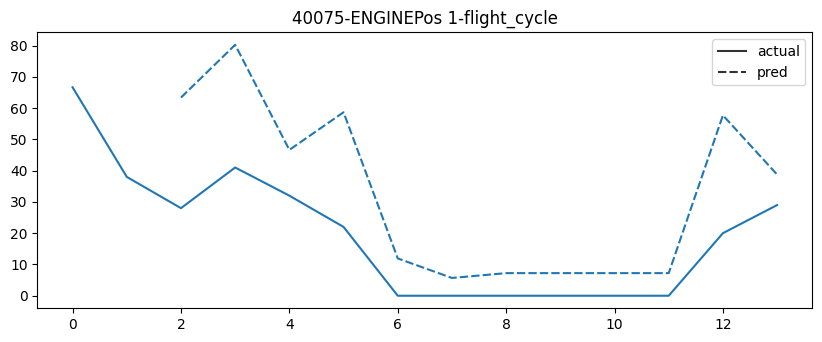

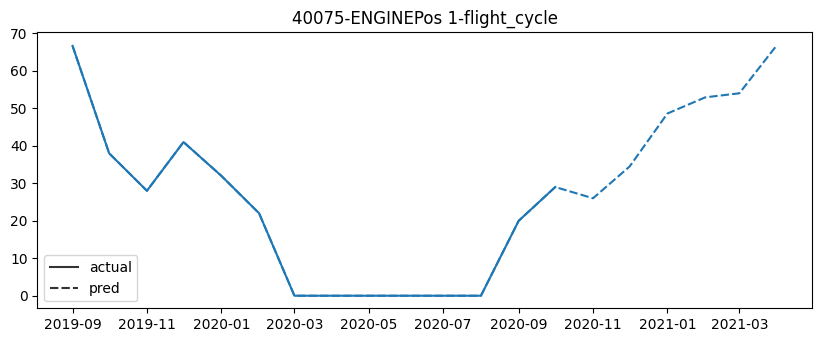

In [65]:
synch_df = model_synched_plot(40075, "ENGINEPos 1", general_fc_lstm_model, "flight_cycle", window_size=WINDOW_SIZE)
forecast_df = model_forecast_plot(40075, "ENGINEPos 1", general_fc_lstm_model, "flight_cycle", period=6)

`41815 ENGINEPos 2`

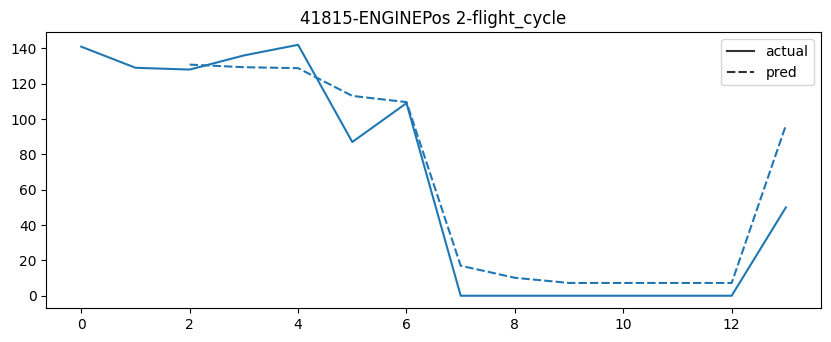

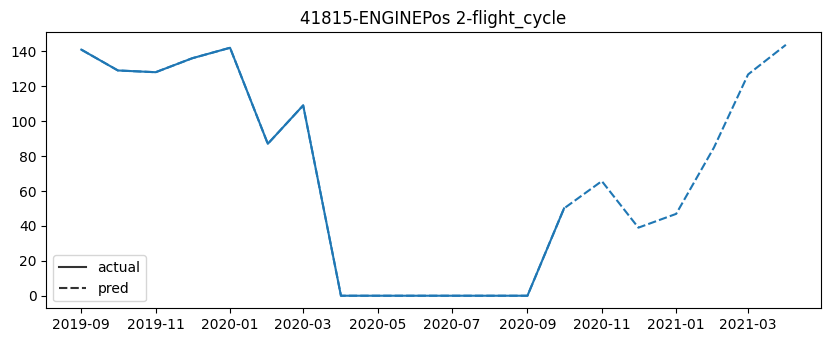

In [66]:
synch_df = model_synched_plot(41815, "ENGINEPos 2", general_fc_lstm_model, "flight_cycle", window_size=WINDOW_SIZE)
forecast_df = model_forecast_plot(41815, "ENGINEPos 2", general_fc_lstm_model, "flight_cycle", period=6)

`1577 APU`

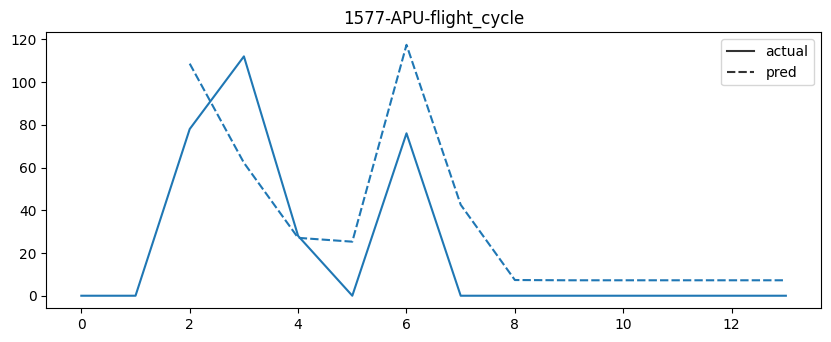

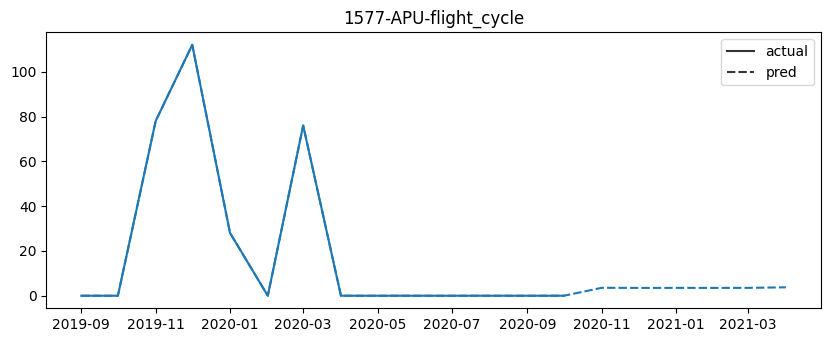

In [67]:
synch_df = model_synched_plot(1577, "APU", general_fc_lstm_model, "flight_cycle", window_size=WINDOW_SIZE)
forecast_df = model_forecast_plot(1577, "APU", general_fc_lstm_model, "flight_cycle", period=6)

#### GRU

`40075 ENGINEPos 1`

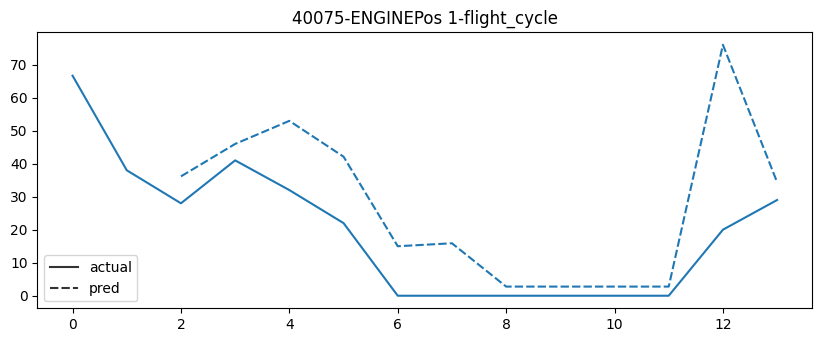

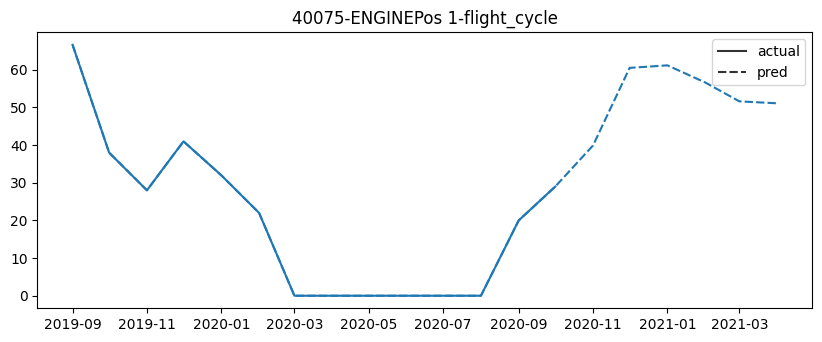

In [68]:
synch_df = model_synched_plot(40075, "ENGINEPos 1", general_fc_gru_model, "flight_cycle", window_size=WINDOW_SIZE)
forecast_df = model_forecast_plot(40075, "ENGINEPos 1", general_fc_gru_model, "flight_cycle", period=6)

`41815 ENGINEPos 2`

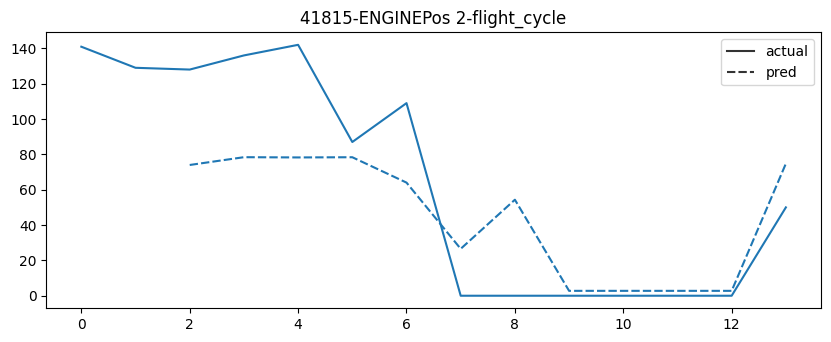

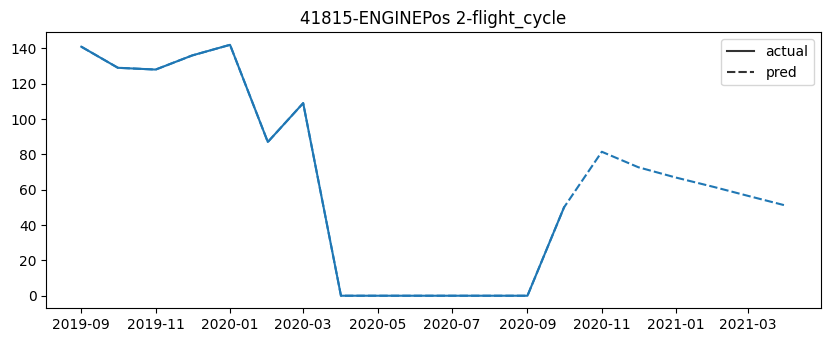

In [69]:
synch_df = model_synched_plot(41815, "ENGINEPos 2", general_fc_gru_model, "flight_cycle", window_size=WINDOW_SIZE)
forecast_df = model_forecast_plot(41815, "ENGINEPos 2", general_fc_gru_model, "flight_cycle", period=6)

`1577 APU`

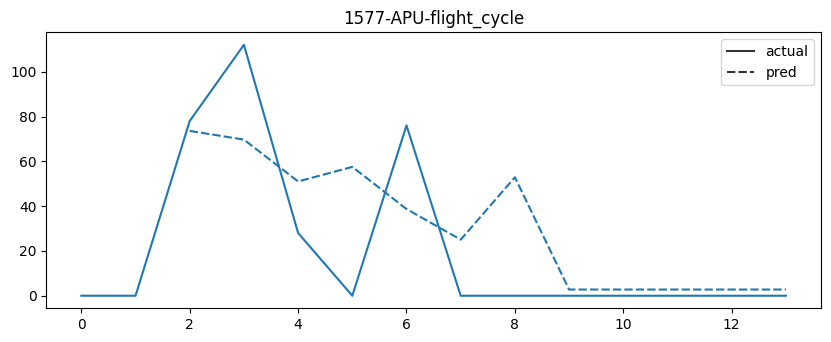

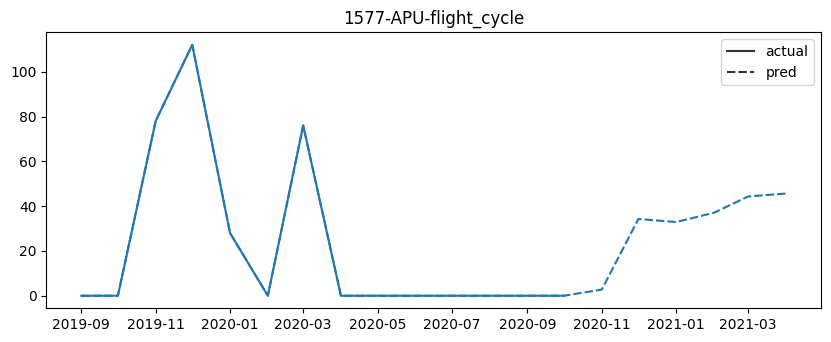

In [70]:
synch_df = model_synched_plot(1577, "APU", general_fc_gru_model, "flight_cycle", window_size=WINDOW_SIZE)
forecast_df = model_forecast_plot(1577, "APU", general_fc_gru_model, "flight_cycle", period=6)

#### RNN

`40075 ENGINEPos 1`

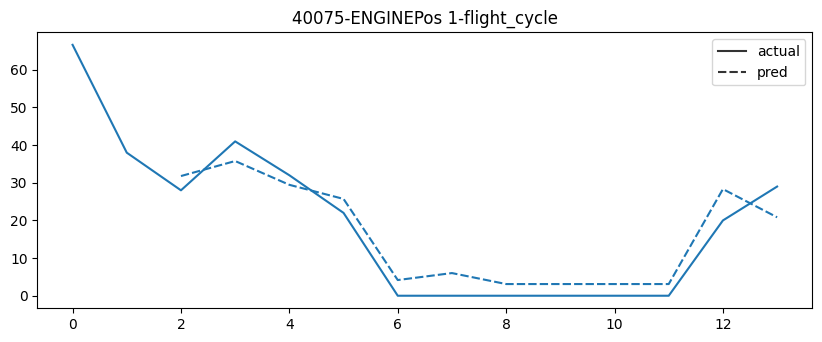

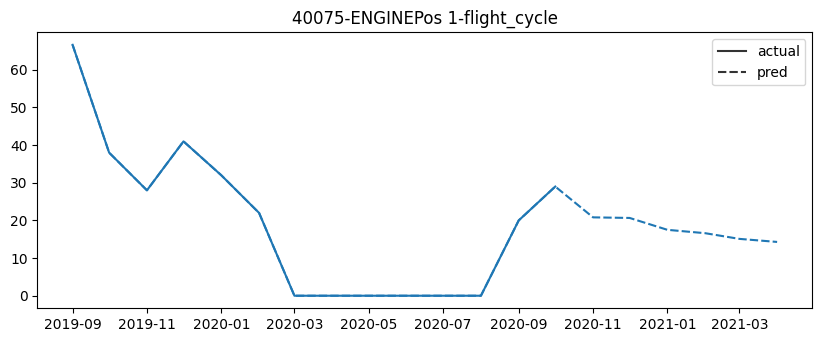

In [71]:
synch_df = model_synched_plot(40075, "ENGINEPos 1", general_fc_rnn_model, "flight_cycle", window_size=WINDOW_SIZE)
forecast_df = model_forecast_plot(40075, "ENGINEPos 1", general_fc_rnn_model, "flight_cycle", period=6)

`41815 ENGINEPos 2`

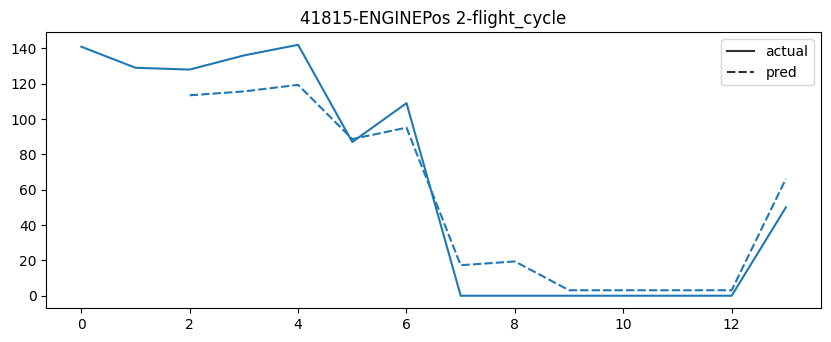

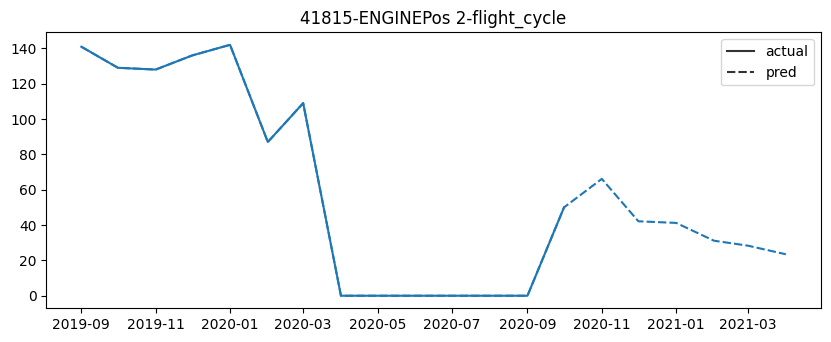

In [72]:
synch_df = model_synched_plot(41815, "ENGINEPos 2", general_fc_rnn_model, "flight_cycle", window_size=WINDOW_SIZE)
forecast_df = model_forecast_plot(41815, "ENGINEPos 2", general_fc_rnn_model, "flight_cycle", period=6)

`1577 APU`

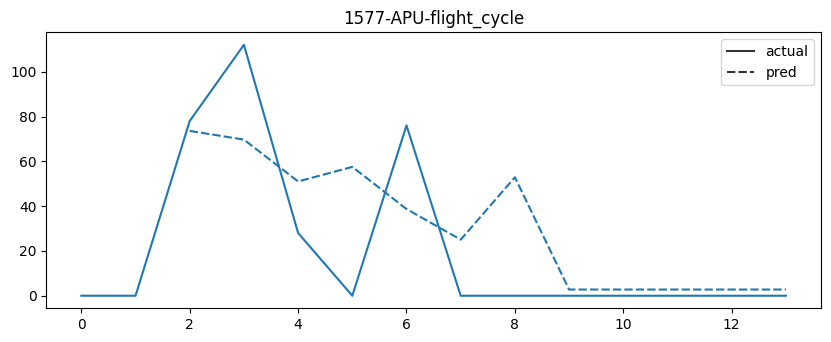

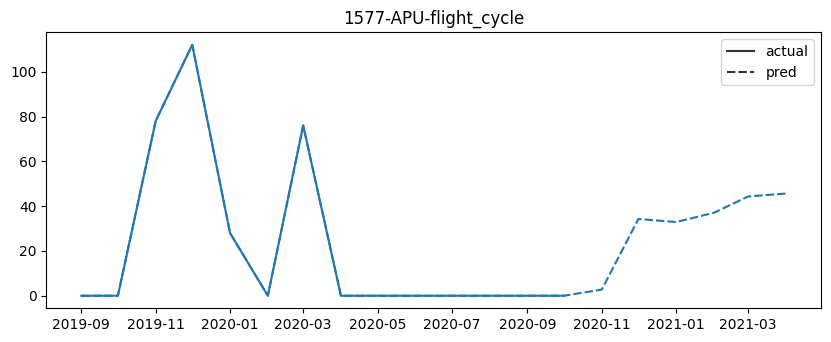

In [73]:
synch_df = model_synched_plot(1577, "APU", general_fc_gru_model, "flight_cycle", window_size=WINDOW_SIZE)
forecast_df = model_forecast_plot(1577, "APU", general_fc_gru_model, "flight_cycle", period=6)

### General flight hour models

#### LSTM

`40075 ENGINEPos 1`

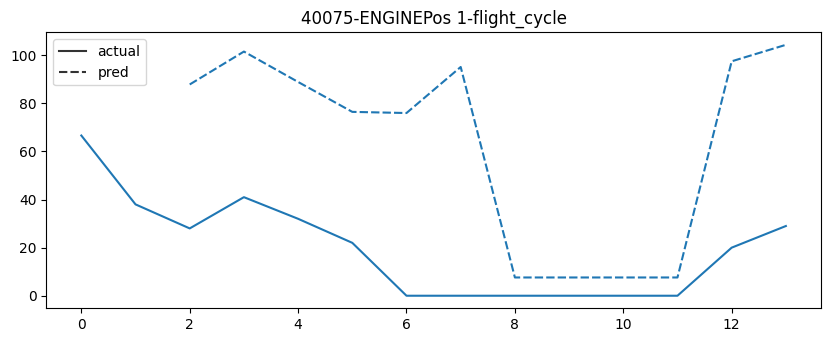

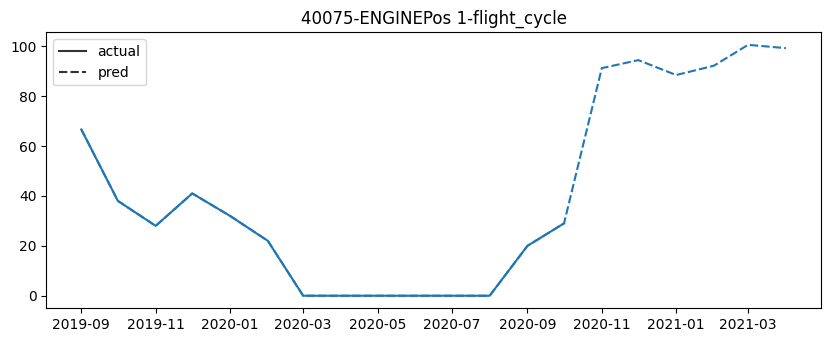

In [74]:
synch_df = model_synched_plot(40075, "ENGINEPos 1", general_fh_lstm_model, "flight_cycle", window_size=WINDOW_SIZE)
forecast_df = model_forecast_plot(40075, "ENGINEPos 1", general_fh_lstm_model, "flight_cycle", period=6)

`41815 ENGINEPos 2`

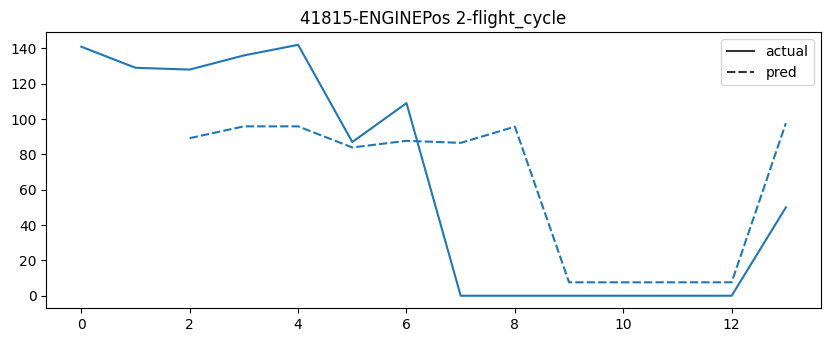

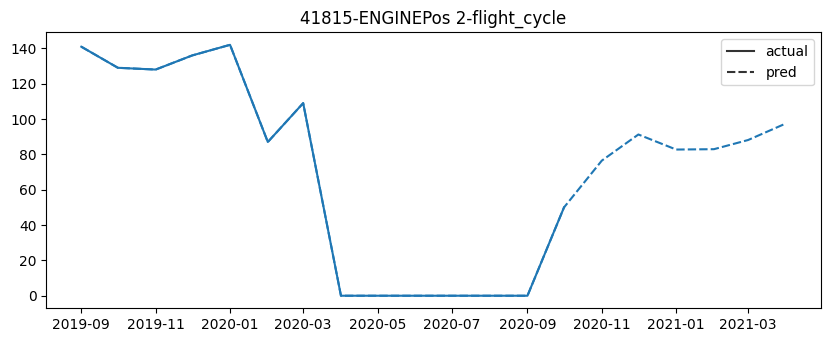

In [75]:
synch_df = model_synched_plot(41815, "ENGINEPos 2", general_fh_lstm_model, "flight_cycle", window_size=WINDOW_SIZE)
forecast_df = model_forecast_plot(41815, "ENGINEPos 2", general_fh_lstm_model, "flight_cycle", period=6)

`1577 APU`

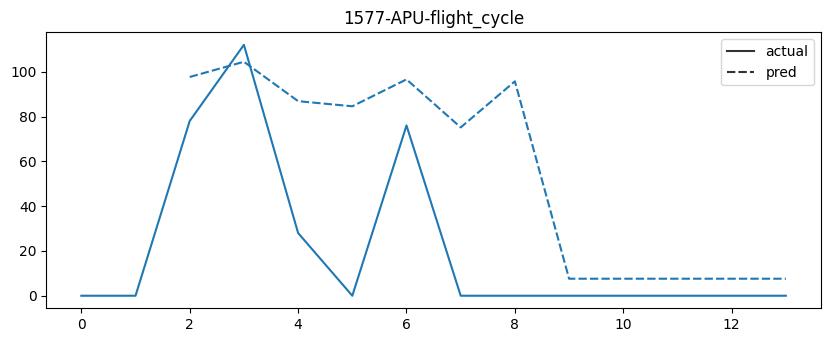

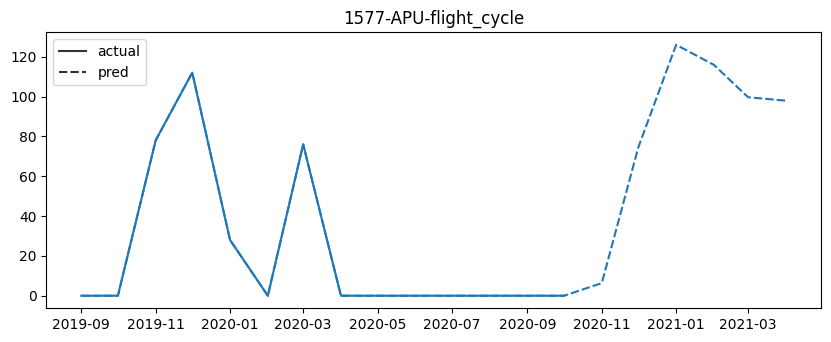

In [76]:
synch_df = model_synched_plot(1577, "APU", general_fh_lstm_model, "flight_cycle", window_size=WINDOW_SIZE)
forecast_df = model_forecast_plot(1577, "APU", general_fh_lstm_model, "flight_cycle", period=6)

#### GRU

`40075 ENGINEPos 1`

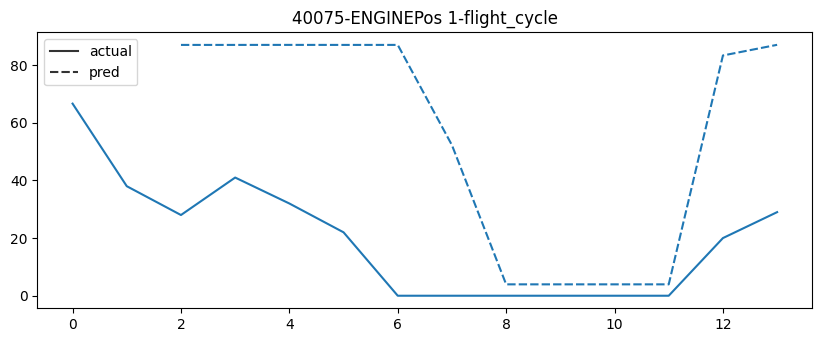

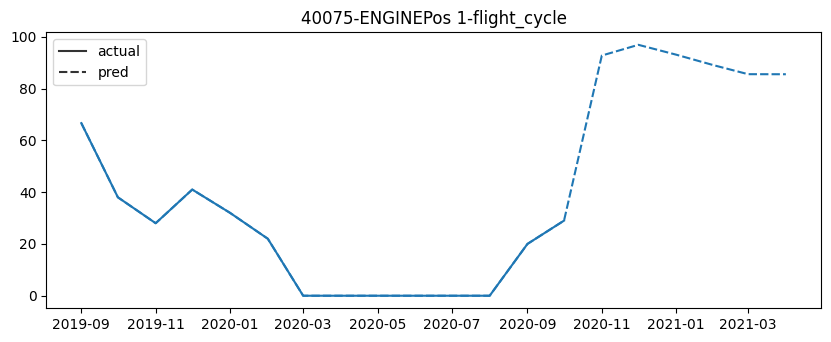

In [77]:
synch_df = model_synched_plot(40075, "ENGINEPos 1", general_fh_gru_model, "flight_cycle", window_size=WINDOW_SIZE)
forecast_df = model_forecast_plot(40075, "ENGINEPos 1", general_fh_gru_model, "flight_cycle", period=6)

`41815 ENGINEPos 2`

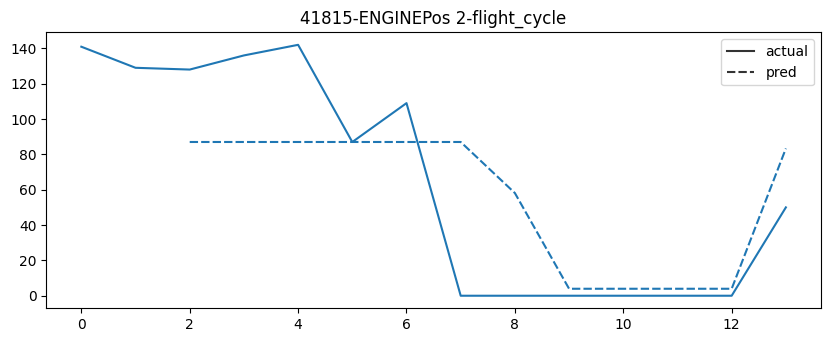

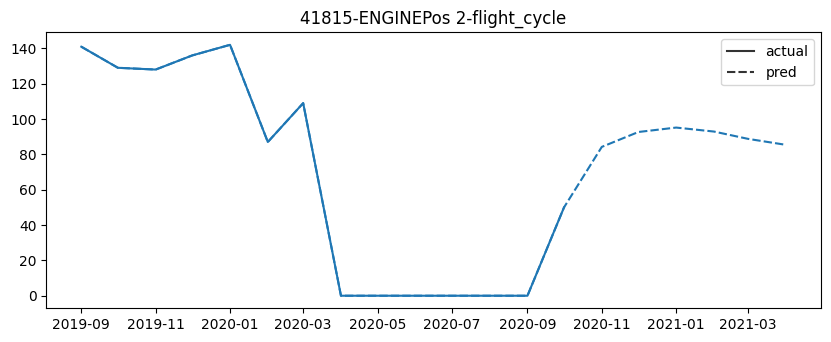

In [78]:
synch_df = model_synched_plot(41815, "ENGINEPos 2", general_fh_gru_model, "flight_cycle", window_size=WINDOW_SIZE)
forecast_df = model_forecast_plot(41815, "ENGINEPos 2", general_fh_gru_model, "flight_cycle", period=6)

`1577 APU`

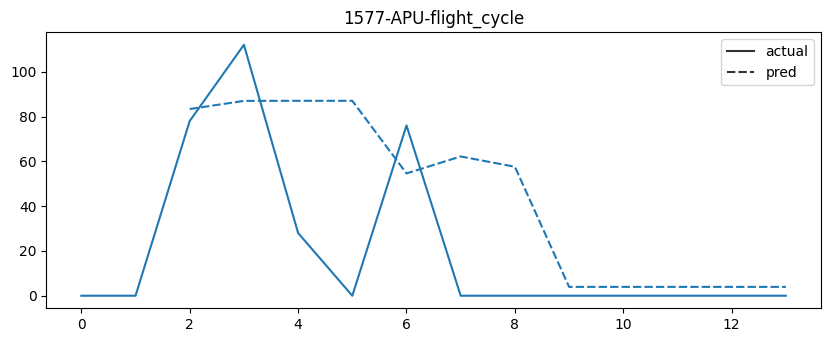

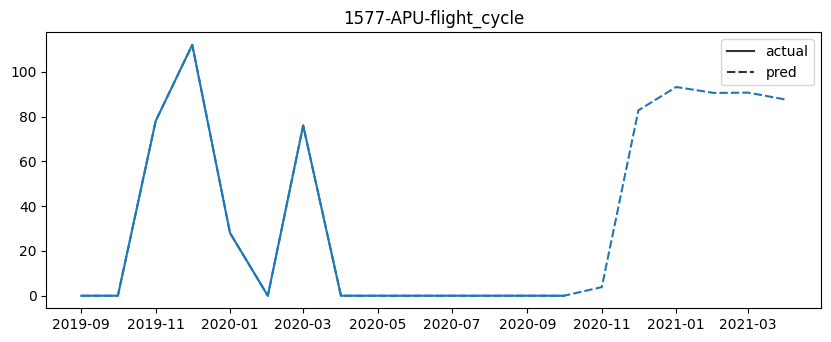

In [79]:
synch_df = model_synched_plot(1577, "APU", general_fh_gru_model, "flight_cycle", window_size=WINDOW_SIZE)
forecast_df = model_forecast_plot(1577, "APU", general_fh_gru_model, "flight_cycle", period=6)

#### RNN

`40075 ENGINEPos 1`

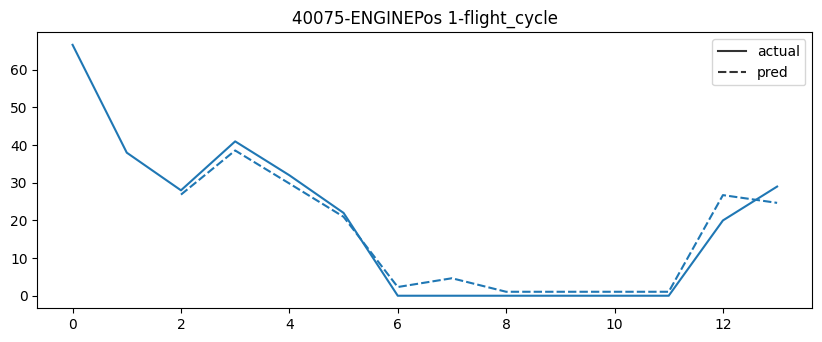

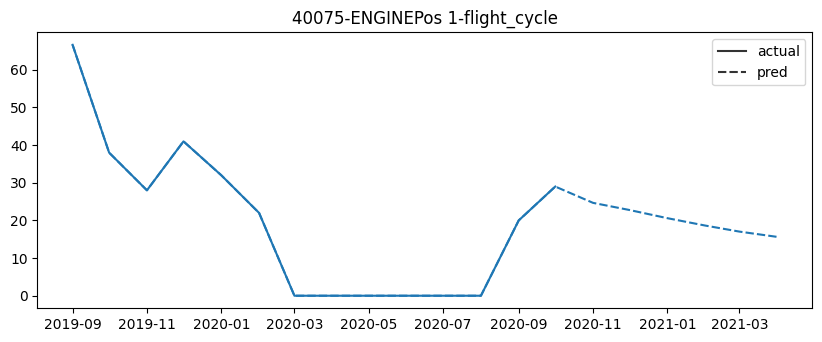

In [80]:
synch_df = model_synched_plot(40075, "ENGINEPos 1", general_fh_rnn_model, "flight_cycle", window_size=WINDOW_SIZE)
forecast_df = model_forecast_plot(40075, "ENGINEPos 1", general_fh_rnn_model, "flight_cycle", period=6)

`41815 ENGINEPos 2`

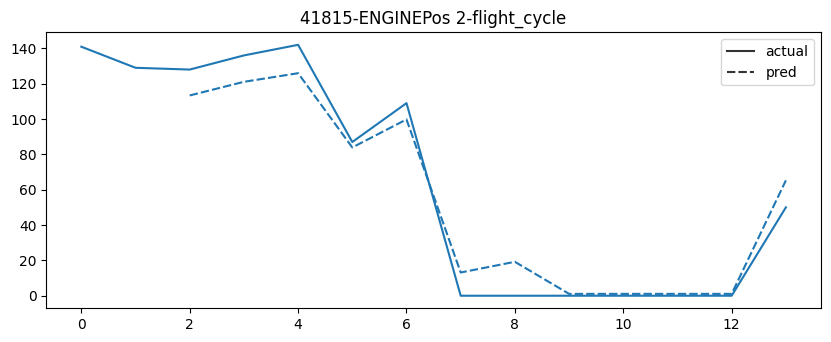

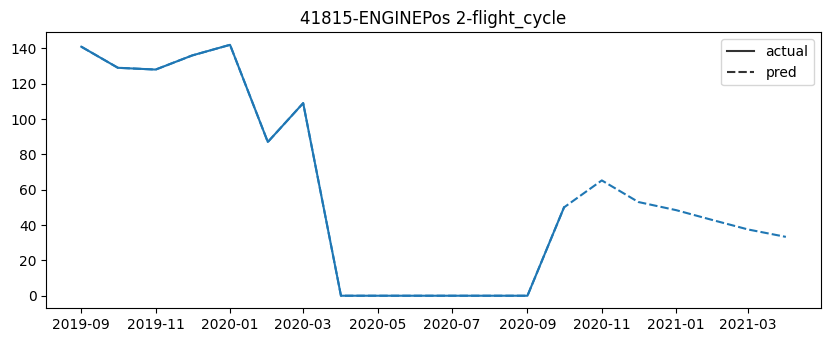

In [81]:
synch_df = model_synched_plot(41815, "ENGINEPos 2", general_fh_rnn_model, "flight_cycle", window_size=WINDOW_SIZE)
forecast_df = model_forecast_plot(41815, "ENGINEPos 2", general_fh_rnn_model, "flight_cycle", period=6)

`1577 APU`

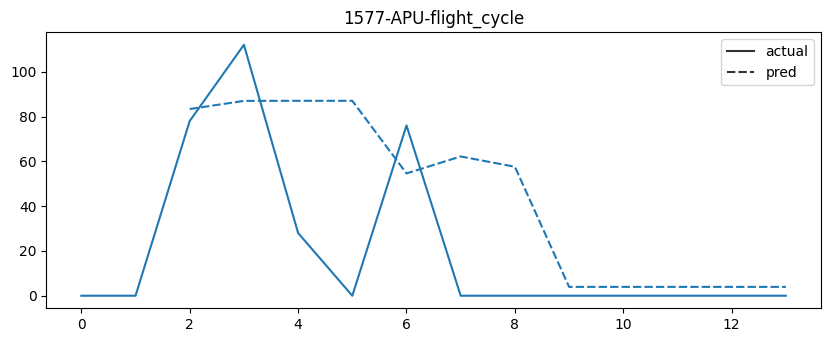

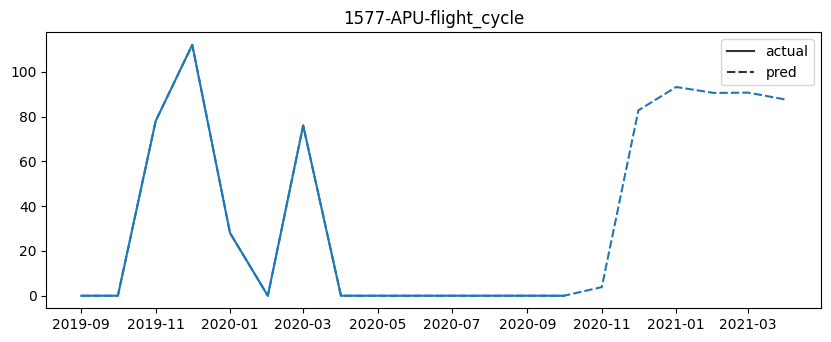

In [82]:
synch_df = model_synched_plot(1577, "APU", general_fh_gru_model, "flight_cycle", window_size=WINDOW_SIZE)
forecast_df = model_forecast_plot(1577, "APU", general_fh_gru_model, "flight_cycle", period=6)

## Conclusion

In this project, we explored the use of RNN, LSTM, and GRU cells for predicting the flight cycle and flight hour in a predictive maintenance scenario. We trained and evaluated three types of models for each prediction task: RNN, LSTM, and GRU.

The results showed that the RNN models consistently outperformed the GRU and LSTM models in terms of root mean squared error (RMSE) on the test set. Specifically, the RNN model achieved an RMSE of 25.93 for flight cycle prediction and 29.08 for flight hour prediction.

These results suggests that RNN models can be effective for predicting flight cycle and flight hour in a predictive maintenance scenario, even when the training data is limited. **However**, given that the total data used for training, validation, and testing only consisted of 2398 rows, these results should be taken with caution and further experimentation with larger datasets is recommended.

## Saving all models

Don't forget to save all the models after our experiment

### General flight cycle models

#### LSTM

In [83]:
general_fc_lstm_model.save(f"./{MODEL_DIR}/general_fc/lstm")

INFO:tensorflow:Assets written to: ./models/general_fc/lstm/assets


INFO:tensorflow:Assets written to: ./models/general_fc/lstm/assets


#### GRU

In [84]:
general_fc_gru_model.save(f"./{MODEL_DIR}/general_fc/gru")

INFO:tensorflow:Assets written to: ./models/general_fc/gru/assets


INFO:tensorflow:Assets written to: ./models/general_fc/gru/assets


#### RNN

In [85]:
general_fc_rnn_model.save(f"./{MODEL_DIR}/general_fc/rnn")

INFO:tensorflow:Assets written to: ./models/general_fc/rnn/assets


INFO:tensorflow:Assets written to: ./models/general_fc/rnn/assets


### General flight hour models

#### LSTM

In [86]:
general_fh_lstm_model.save(f"./{MODEL_DIR}/general_fh/lstm")

INFO:tensorflow:Assets written to: ./models/general_fh/lstm/assets


INFO:tensorflow:Assets written to: ./models/general_fh/lstm/assets


#### GRU

In [87]:
general_fh_gru_model.save(f"./{MODEL_DIR}/general_fh/gru")

INFO:tensorflow:Assets written to: ./models/general_fh/gru/assets


INFO:tensorflow:Assets written to: ./models/general_fh/gru/assets


#### RNN

In [88]:
general_fh_rnn_model.save(f"./{MODEL_DIR}/general_fh/rnn")

INFO:tensorflow:Assets written to: ./models/general_fh/rnn/assets


INFO:tensorflow:Assets written to: ./models/general_fh/rnn/assets
